In [1]:
library(survival)
library(ggplot2)
library(dplyr)
library(reshape2)
library(stringr)

Warning message:
“package ‘survival’ was built under R version 4.0.5”
Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘reshape2’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”


In [2]:
dir_fig = 'R_clogit/for_publish_v5/'
#dir_fig = 'R_clogit/for_publish_v5_snooptr/'

file_dir = 'combined_tables/'
#file_dir = 'combined_tables_snooptr/'

file_tr_pca_pb = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/pca_calculation/PC_data_PB.tsv'
file_tr_pca_ont = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/pca_calculation/PC_data_ONT.tsv'
#file_tr_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs/variant_prior/pca_calculation/PC_data.tsv'

# for LongTR
q_suf = '_Q'
# for snoopsv
#q_suf = ''

In [3]:
### clean features
fts = c('PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr', 
        'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 
        'PLIp9_cds + PLIp9_utr', 
        'LOWPLI_cds + LOWPLI_utr', 
        'genic_cds + genic_utr',

        'PLIp9_DEV_BR_GENE_10_intron',
        'DEV_BR_GENE_10_intron', 
        'PLIp9_intron', 
        'LOWPLI_intron', 
        'intergenic', 
        'genic_intron')
fts_labels = c('fetal brain expressed genes with pLI≥.9, exonic', 
               'fetal brain expressed genes, exonic', 
               'pLI≥.9, exonic', 
               'pLI≤.9, exonic', 
               'exonic',

               'fetal brain expressed genes with pLI≥.9, intronic',
               'fetal brain expressed genes, intronic', 
               'pLI≥.9, intronic', 
               'pLI≤.9, intronic', 
               'intergenic', 
               'intronic')
fts_col_names = c('fetal_brain_genes_pli_exonic', 
                  'fetal_brain_genes_exonic', 
                  'pli_genes_exonic', 
                  'lowpli_genes_exonic', 
                  'genic_exonic',
                  'fetal_brain_genes_pli_intronic', 
                  'fetal_brain_genes_intronic', 
                  'pli_genes_intronic', 
                  'lowpli_genes_intronic', 
                  'intergenic', 
                  'genic_intronic')

trs_fts = c(fts, 
            'FDR_ASD_cds + FDR_ASD_utr', 
            'FDR_ASD_intron')
trs_fts_labels = c(fts_labels, 
                   'ASD FDR, exonic',
                   'ASD FDR, intron')
trs_fts_col_names = c(fts_col_names, 
                      'asd_genes_exonic', 
                      'asd_genes_intronic')

In [4]:
get_pval_char <- function(pval) {
    if (pval>0.05) {return('')}
    if ((pval<0.05) && (pval>0.01)) {return('*')}
    else if ((pval<0.01) && (pval>0.001)) {return('**')}
    else {return('***')}
}

In [5]:
#prs_mode = 'sbayesr'
prs_mode = 'prscs'
file_suf = 'SQ70_SAMPLES_AD2_SAMPLES'
if (prs_mode == 'sbayesr') {
    file_main = paste0(file_dir, 'combined_svs_trs_snvs_prs_pc_sbayesr_', file_suf, '.csv')
} else if (prs_mode == 'prscs') {
    file_main = paste0(file_dir, 'combined_svs_trs_snvs_prs_pc_prscs_', file_suf, '.csv')}

df_main <- read.table(file_main, header = TRUE, sep = ",")
#df_main['count_PLIp9_nonLOF_DEV_BR_10_cds'] = df_main[,'count_PLIp9_DEV_BR_GENE_10_cds'] - df_main[,'count_PLIp9_LOF_DEV_BR_10_cds']
df_main[,'Platform'] <- as.factor(df_main[,'Platform'])
df_main[,'sex'] <- as.factor(df_main[,'sex'])
df_main

fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,⋯,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP1,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP1_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP2,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q,PRS_ASD_Z,PRS_SCZ_Z,PRS_EDU_Z,count_dnlof_inhlof
<chr>,<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627126,-0.005607061,⋯,142,126,16,14,0,0,-0.971701072,-0.510485305,0.82162924,0
F0026,REACH000026,ASD,Male,1,trio,1,0,0.095363540,-0.045229620,⋯,1,1,1,1,1,1,0.303644763,0.817056455,0.06312390,1
F0058,REACH000058,ASD,Male,1,trio,1,1,0.002421759,-0.009216429,⋯,5,5,1,1,1,1,0.595643472,-0.305436874,1.94303491,2
F0065,REACH000065,ASD,Male,1,trio,1,0,0.252773800,0.107932900,⋯,0,0,0,0,0,0,1.166191828,0.943709479,-2.78896425,1
F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785250,0.038064880,⋯,2,1,1,0,0,0,0.703902177,-0.152554399,0.06482359,0
F0078,REACH000089,ASD,Female,1,trio,2,0,0.049879690,0.047204300,⋯,1,0,0,0,0,0,0.384605619,0.209070495,0.16440487,0
F0081,REACH000092,ASD,Female,1,trio,1,1,-0.028510680,-0.001001894,⋯,3,3,2,2,1,1,-0.898010204,-0.994547648,0.53088874,1
F0081,REACH000095,CON,Female,1,trio,1,1,-0.030440730,-0.002736118,⋯,1,1,1,1,1,1,-1.036073363,-1.487948561,0.29231934,1
F0083,REACH000097,ASD,Male,1,trio,1,0,0.095793110,0.052887850,⋯,3,2,2,1,1,1,0.817923575,-0.003587407,-0.08546761,1


In [6]:
# SV pca data
file_sv_pca = 'pca_calculation/PC_data.tsv'
df_sv_pca <- read.table(file_sv_pca, header = TRUE, sep = "\t")
#df_sv_pca
#print(df_sv_pca$SAMPLE)

#pca_flt_name = 'SQ70_SAMPLES'
pca_flt_name = 'SQ20_SAMPLES'
#pca_flt_name = 'SQ30_SAMPLES'
pcs = paste0('PC', 1:10, '_', pca_flt_name)
for (pc in pcs) {
    df_main[,pc] <- df_sv_pca[,pc]
}

# TR pca data
df_tr_pca_pb <- read.table(file_tr_pca_pb, header = TRUE, sep = "\t")
df_tr_pca_ont <- read.table(file_tr_pca_ont, header = TRUE, sep = "\t")
dim(df_tr_pca_pb)
dim(df_tr_pca_ont)
# bring the SAMPLE and Platform column to the front
df_tr_pca_pb <- df_tr_pca_pb %>% select(SAMPLE, Platform, everything())
df_tr_pca_ont <- df_tr_pca_ont %>% select(SAMPLE, Platform, everything())
dim(df_tr_pca_pb)
dim(df_tr_pca_ont)
df_tr_pca <- rbind(df_tr_pca_pb, df_tr_pca_ont)
dim(df_tr_pca)
# order the dataframe with the order of samples in df_main
df_tr_pca$SAMPLE <- factor(df_tr_pca$SAMPLE, levels=df_main$iid)
df_tr_pca <- arrange(df_tr_pca, SAMPLE)

#pca_tr_flt_name = 'ZS3_SUPP3'
pca_tr_flt_name = 'ZS3_SUPP2'
pcs = paste0('PC', 1:10, '_', pca_tr_flt_name)
for (pc in pcs) {
    df_main[,pc] <- df_tr_pca[,pc]
}

df_main

df_main_ont = df_main %>% filter(Platform == 'ONT')
df_main_pb = df_main %>% filter(Platform == 'PB')

print(dim(df_main_ont))
print(dim(df_main_pb))

[1] 142  22

[1] 101  22

[1] 142  22

[1] 101  22

[1] 243  22

fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,⋯,PC1_ZS3_SUPP2,PC2_ZS3_SUPP2,PC3_ZS3_SUPP2,PC4_ZS3_SUPP2,PC5_ZS3_SUPP2,PC6_ZS3_SUPP2,PC7_ZS3_SUPP2,PC8_ZS3_SUPP2,PC9_ZS3_SUPP2,PC10_ZS3_SUPP2
<chr>,<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627126,-0.005607061,⋯,-5.7428383,-9.7398957,-9.9529145,10.81974024,-18.377149,-47.6953060,-66.55890326,247.2290792,-5.6458614,33.49369560
F0026,REACH000026,ASD,Male,1,trio,1,0,0.095363540,-0.045229620,⋯,-3.4027336,0.2802879,-1.6638668,-0.13247137,-4.263263,-0.6661540,-3.18005758,-0.5572458,-1.5303198,-0.06147496
F0058,REACH000058,ASD,Male,1,trio,1,1,0.002421759,-0.009216429,⋯,-5.1641087,-3.7235760,2.2352874,4.85880950,-1.271991,-1.5503321,-1.71098263,1.9802102,5.0107614,1.98556791
F0065,REACH000065,ASD,Male,1,trio,1,0,0.252773800,0.107932900,⋯,-3.7359969,-0.9440220,-1.4531937,0.41047860,-4.292613,-0.5023412,-3.00212212,-0.6445512,-1.8320331,-0.15669520
F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785250,0.038064880,⋯,-3.6808493,-0.6646748,-1.8285393,0.48767277,-4.304083,0.6053316,-2.80995264,-0.2304147,-2.7608073,-0.26025369
F0078,REACH000089,ASD,Female,1,trio,2,0,0.049879690,0.047204300,⋯,-4.2433004,-0.6657188,-2.0864793,0.42770884,-4.559075,-0.3396236,-2.28247896,-1.8967525,-0.3218728,0.48014594
F0081,REACH000092,ASD,Female,1,trio,1,1,-0.028510680,-0.001001894,⋯,-5.9785335,-3.6871056,-1.0274156,0.34372825,-6.040563,0.4431568,-4.65274462,-4.9426990,1.4183087,2.25440107
F0081,REACH000095,CON,Female,1,trio,1,1,-0.030440730,-0.002736118,⋯,-3.7672175,-2.7852211,-1.6907567,-0.58150699,-3.800280,0.5116337,-5.58558884,-4.0815097,0.3801025,0.42605646
F0083,REACH000097,ASD,Male,1,trio,1,0,0.095793110,0.052887850,⋯,0.1746713,-4.6008105,-5.5409058,3.77664981,-6.132212,-4.8840313,-1.16832008,-6.2127484,20.0205774,-2.86344729


[1]  101 1796
[1]  142 1796


In [13]:
# make extra SV PCA variables
pca_vars = paste0('PC', 1:10, '_', pca_flt_name)
pca_var_str = paste(pca_vars, collapse=' + ')
pca_var_str

# make extra TR PCA variables
pca_mode = 'reg'
#pca_mode = 'null'
#pca_mode = 'sv'
pca_tr_vars = paste0('PC', 1:10, '_', pca_tr_flt_name)
pca_tr_var_str = paste(pca_tr_vars, collapse=' + ')
if (pca_mode == 'reg') {
    pca_suff = paste0('pca_', pca_tr_flt_name)
} else if (pca_mode == 'null') {
    pca_suff = paste0('pca_', 'null')
    pca_tr_var_str = ''
} else if (pca_mode == 'sv') {
    pca_suff = paste0('pca_', pca_flt_name)
    pca_tr_var_str = pca_var_str
}
pca_tr_var_str
pca_suff

[1] "PC1_SQ20_SAMPLES + PC2_SQ20_SAMPLES + PC3_SQ20_SAMPLES + PC4_SQ20_SAMPLES + PC5_SQ20_SAMPLES + PC6_SQ20_SAMPLES + PC7_SQ20_SAMPLES + PC8_SQ20_SAMPLES + PC9_SQ20_SAMPLES + PC10_SQ20_SAMPLES"

[1] "PC1_ZS3_SUPP2 + PC2_ZS3_SUPP2 + PC3_ZS3_SUPP2 + PC4_ZS3_SUPP2 + PC5_ZS3_SUPP2 + PC6_ZS3_SUPP2 + PC7_ZS3_SUPP2 + PC8_ZS3_SUPP2 + PC9_ZS3_SUPP2 + PC10_ZS3_SUPP2"

[1] "pca_ZS3_SUPP2"

In [15]:
### SVs All
#PRINT_INFO = TRUE
PRINT_INFO = FALSE

flt = 'SQ70' # file_main is built with this SV filter. if you want to change the SV filter you should regenerate the file_main

#null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + 
#                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')
null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str,
                          '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (ft in fts) {

    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste0('count_', ft_tmp) # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    #new_df[c(ft_tmp, 'new_var')]

    #var = paste('count_', ft, sep="")
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    #model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
    #                                 PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data = data.frame('fts' = fts, 'fts_labels' = fts_labels, 
                     'log_ORs' = log_ORs, 'log_ORs_plus' = log_ORs_plus, 'log_ORs_minus' = log_ORs_minus, 
                     'ano_pval' = ano_pvals, 
                     'sum_case_con' = sum_case_controls)

[1] "no extra covariates......................."
[1] "count_PLIp9_DEV_BR_GENE_10_cds" "count_PLIp9_DEV_BR_GENE_10_utr"
[1] "count_DEV_BR_GENE_10_cds" "count_DEV_BR_GENE_10_utr"
[1] "count_PLIp9_cds" "count_PLIp9_utr"
[1] "count_LOWPLI_cds" "count_LOWPLI_utr"
[1] "count_genic_cds" "count_genic_utr"
[1] "count_PLIp9_DEV_BR_GENE_10_intron"
[1] "count_DEV_BR_GENE_10_intron"
[1] "count_PLIp9_intron"
[1] "count_LOWPLI_intron"
[1] "count_intergenic"
[1] "count_genic_intron"


In [16]:
### SVs ONT
#PRINT_INFO = TRUE
PRINT_INFO = FALSE

flt = 'SQ70' # file_main is built with this SV filter. if you want to change the SV filter you should regenerate the file_main

#null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + 
#                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')
null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str,
                          '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (ft in fts) {

    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste0('count_', ft_tmp) # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main_ont
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main_ont[ft_]
    }
    #new_df[c(ft_tmp, 'new_var')]

    #var = paste('count_', ft, sep="")
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    #model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
    #                                 PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_all_ont = cbind(my_data, data.frame('log_ORs_ont' = log_ORs, 'log_ORs_plus_ont' = log_ORs_plus, 'log_ORs_minus_ont' = log_ORs_minus, 
                     'ano_pval_ont' = ano_pvals, 
                     'sum_case_con_ont' = sum_case_controls))

[1] "no extra covariates......................."
[1] "count_PLIp9_DEV_BR_GENE_10_cds" "count_PLIp9_DEV_BR_GENE_10_utr"
[1] "count_DEV_BR_GENE_10_cds" "count_DEV_BR_GENE_10_utr"
[1] "count_PLIp9_cds" "count_PLIp9_utr"
[1] "count_LOWPLI_cds" "count_LOWPLI_utr"
[1] "count_genic_cds" "count_genic_utr"
[1] "count_PLIp9_DEV_BR_GENE_10_intron"
[1] "count_DEV_BR_GENE_10_intron"
[1] "count_PLIp9_intron"
[1] "count_LOWPLI_intron"
[1] "count_intergenic"
[1] "count_genic_intron"


In [17]:
### SVs PB
#PRINT_INFO = TRUE
PRINT_INFO = FALSE

flt = 'SQ70' # file_main is built with this SV filter. if you want to change the SV filter you should regenerate the file_main

#null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + 
#                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')
null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str,
                          '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (ft in fts) {

    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste0('count_', ft_tmp) # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main_pb
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main_pb[ft_]
    }
    #new_df[c(ft_tmp, 'new_var')]

    #var = paste('count_', ft, sep="")
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    #model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
    #                                 PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_var_str,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_all_ont_pb = cbind(my_data_all_ont, data.frame('log_ORs_pb' = log_ORs, 'log_ORs_plus_pb' = log_ORs_plus, 'log_ORs_minus_pb' = log_ORs_minus, 
                     'ano_pval_pb' = ano_pvals, 
                     'sum_case_con_pb' = sum_case_controls))

[1] "no extra covariates......................."
[1] "count_PLIp9_DEV_BR_GENE_10_cds" "count_PLIp9_DEV_BR_GENE_10_utr"
[1] "count_DEV_BR_GENE_10_cds" "count_DEV_BR_GENE_10_utr"
[1] "count_PLIp9_cds" "count_PLIp9_utr"
[1] "count_LOWPLI_cds" "count_LOWPLI_utr"
[1] "count_genic_cds" "count_genic_utr"
[1] "count_PLIp9_DEV_BR_GENE_10_intron"
[1] "count_DEV_BR_GENE_10_intron"
[1] "count_PLIp9_intron"
[1] "count_LOWPLI_intron"
[1] "count_intergenic"
[1] "count_genic_intron"


[1] "R_clogit/for_publish_v5/SVs_burden_platform.png"


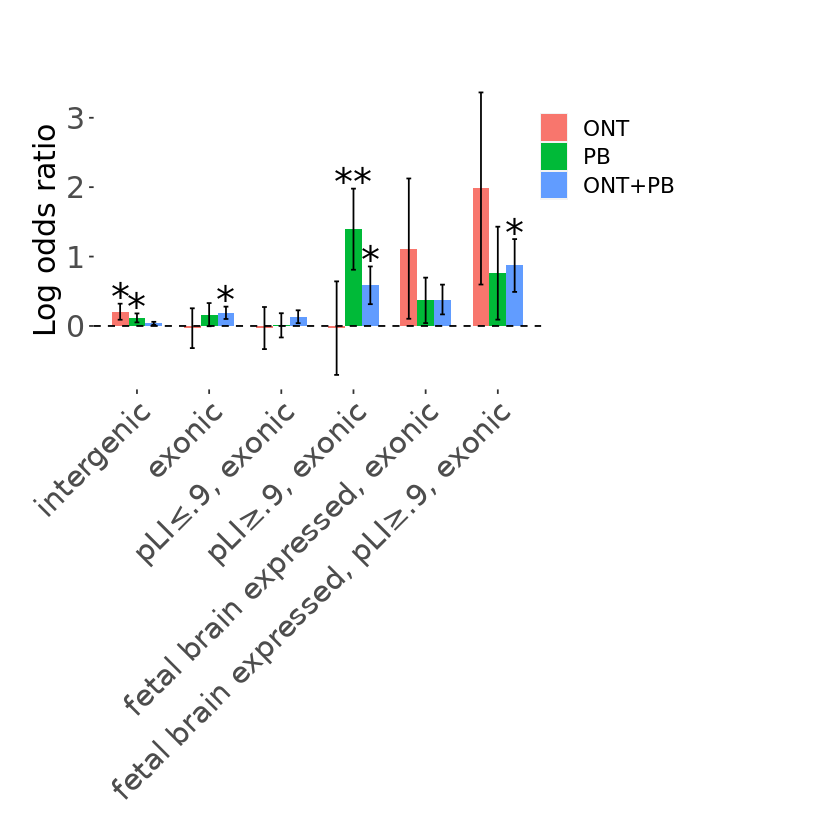

In [18]:
# plot SVs, platform
sub_fts_labels = c('intergenic', 'exonic',
                   'pLI≤.9, exonic', 'pLI≥.9, exonic', 
                   'fetal brain expressed, exonic', 'fetal brain expressed, pLI≥.9, exonic')
sub_fts = c('intergenic', 'genic_cds + genic_utr',  
            'LOWPLI_cds + LOWPLI_utr', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')

#sub_fts_labels = c('intergenic', 'pLI≤.9, intronic', 'pLI≤.9, exonic', 'pLI≥.9, intronic', 'pLI≥.9, exonic', 
#                   'fetal brain expressed, intronic', 'fetal brain expressed, exonic', 
#                   'fetal brain expressed, pLI≥.9, intronic', 'fetal brain expressed, pLI≥.9, exonic')
#sub_fts = c('intergenic', 'LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr', 'PLIp9_intron', 'PLIp9_cds + PLIp9_utr', 
#            'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 
#            'PLIp9_DEV_BR_GENE_10_intron', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')
fig_base = 'SVs_burden_platform'

my_data_sub = my_data_all_ont_pb[my_data_all_ont_pb$fts %in% sub_fts,]
my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)

my_data_sub.melt = melt(my_data_sub, id.vars = c('fts', 'fts_labels', 
                                                 'log_ORs_plus', 'log_ORs_minus', 
                                                 'ano_pval', 
                                                 'sum_case_con', 
                                                 'log_ORs_plus_ont', 'log_ORs_minus_ont', 
                                                 'ano_pval_ont', 
                                                 'sum_case_con_ont',
                                                 'log_ORs_plus_pb', 'log_ORs_minus_pb', 
                                                 'ano_pval_pb', 
                                                 'sum_case_con_pb'), 
                        variable.name = 'lor_type', value.name = 'log_ORs')

lor_type_levels = c('log_ORs_ont', 'log_ORs_pb', 'log_ORs')
my_data_sub.melt$lor_type = factor(my_data_sub.melt$lor_type, levels = lor_type_levels)

my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_plus = ifelse(lor_type=='log_ORs', log_ORs_plus,
                                                                             ifelse(lor_type=='log_ORs_ont', log_ORs_plus_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', log_ORs_plus_pb, '.'))))
my_data_sub.melt[,'log_ORs_plus'] <- as.double(my_data_sub.melt[,'log_ORs_plus'])

my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_minus = ifelse(lor_type=='log_ORs', log_ORs_minus,
                                                                             ifelse(lor_type=='log_ORs_ont', log_ORs_minus_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', log_ORs_minus_pb, '.'))))
my_data_sub.melt[,'log_ORs_minus'] <- as.double(my_data_sub.melt[,'log_ORs_minus'])

my_data_sub.melt <- transform(my_data_sub.melt, ano_pval = ifelse(lor_type=='log_ORs', ano_pval,
                                                                             ifelse(lor_type=='log_ORs_ont', ano_pval_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', ano_pval_pb, '.'))))
my_data_sub.melt[,'ano_pval'] <- as.double(my_data_sub.melt[,'ano_pval'])

sig <- sapply(my_data_sub.melt$ano_pval, get_pval_char)
my_data_sub.melt$sig = sig

#my_data_sub.melt

size_txt = 18
size_sig = 8
ylim_min = -0.1
ylim_max = 1.5

fig_name = paste0(dir_fig, fig_base, ".png")

base <- ggplot(my_data_sub.melt, aes(x = fts, y = log_ORs, fill = lor_type, ymin=log_ORs_minus , ymax=log_ORs_plus)) +
  geom_bar(position = position_dodge(width=0.7), stat = "identity", width = 0.7) +
  geom_errorbar(position = position_dodge(width=0.7), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=0.7), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
  labs(y = "Log odds ratio", title = '') +
  theme(axis.text=element_text(size=size_txt),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1., size=size_txt),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size=size_txt),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5, size=size_txt), 
        legend.position = c(1.15, 0.8),
        legend.text = element_text(size=size_txt-5),
        legend.title = element_text(size=size_txt),
        plot.margin = margin(20, 180, 20, 20) # Add margins: top, right, bottom, left (in points)
        ) +
  scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) +
  #scale_fill_discrete(name = 'Subjects', labels = c("combined", "SNV/indel non-carriers"), values = c("red", "green")) + 
  scale_fill_discrete(name = '', labels = c("ONT", "PB", "ONT+PB"))
  #scale_fill_manual(name = 'Subjects', labels = c("combined", "excluding case subjects with dnLOF, dnMIS and InhLOF SNVs/indels"), values=c("khaki", "indianred1")) +

#if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(ylim_min, 2))}
#base <- base + ylim(c(ylim_min, ylim_max))

print(fig_name)
print(base)
ggsave(fig_name, width = 10, height = 8)

[1] "R_clogit/for_publish_v5/SVs_burden_main.png"


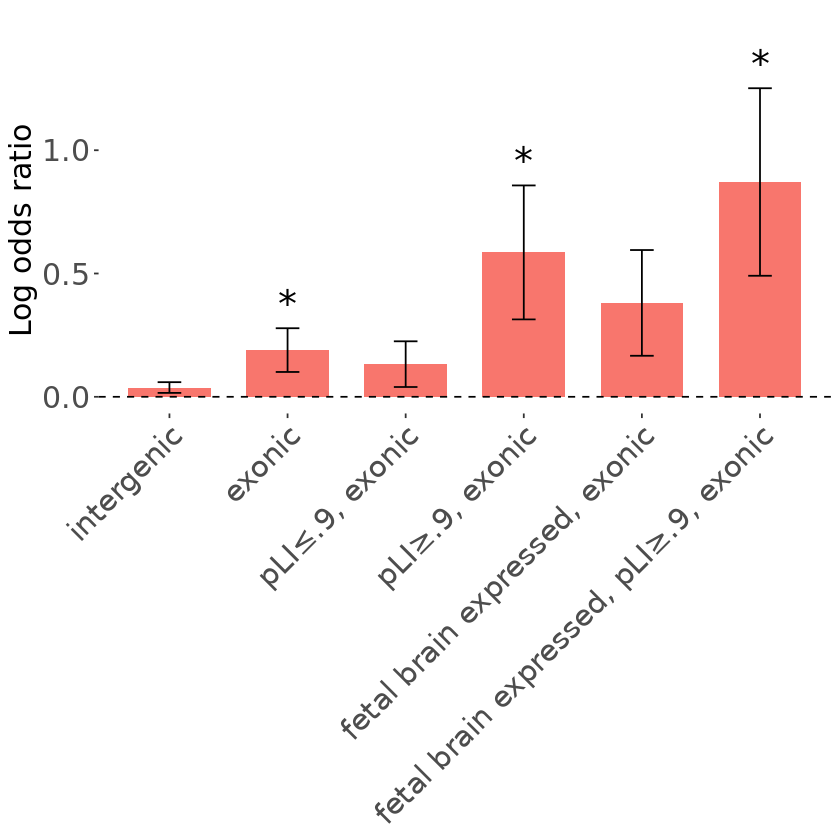

In [19]:
# plot SVs, main
sub_fts_labels = c('intergenic', 'exonic',
                   'pLI≤.9, exonic', 'pLI≥.9, exonic', 
                   'fetal brain expressed, exonic', 'fetal brain expressed, pLI≥.9, exonic')
sub_fts = c('intergenic', 'genic_cds + genic_utr',  
            'LOWPLI_cds + LOWPLI_utr', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')

#sub_fts_labels = c('intergenic', 'pLI≤.9, intronic', 'pLI≤.9, exonic', 'pLI≥.9, intronic', 'pLI≥.9, exonic', 
#                   'fetal brain expressed, intronic', 'fetal brain expressed, exonic', 
#                   'fetal brain expressed, pLI≥.9, intronic', 'fetal brain expressed, pLI≥.9, exonic')
#sub_fts = c('intergenic', 'LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr', 'PLIp9_intron', 'PLIp9_cds + PLIp9_utr', 
#            'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 
#            'PLIp9_DEV_BR_GENE_10_intron', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')
fig_base = 'SVs_burden_main'

my_data_sub = my_data_all_ont_pb[my_data_all_ont_pb$fts %in% sub_fts,]
my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)

sig <- sapply(my_data_sub$ano_pval, get_pval_char)
my_data_sub$sig = sig

#my_data_sub

size_txt = 18
size_sig = 8
ylim_min = -0.1
ylim_max = 1.5

fig_name = paste0(dir_fig, fig_base, ".png")

base <- ggplot(my_data_sub, aes(x = fts, y = log_ORs, fill = 'ref', ymin=log_ORs_minus , ymax=log_ORs_plus)) +
  geom_bar(position = position_dodge(width=0.7), stat = "identity", width = 0.7) +
  geom_errorbar(position = position_dodge(width=0.7), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=0.7), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
  labs(y = "Log odds ratio", title = '') +
  theme(axis.text=element_text(size=size_txt),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1., size=size_txt),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size=size_txt),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5, size=size_txt), 
        legend.position = 'none',
        #legend.position = c(1.15, 0.8),
        #legend.text = element_text(size=size_txt-5),
        #legend.title = element_text(size=size_txt),
        #plot.margin = margin(20, 180, 20, 20) # Add margins: top, right, bottom, left (in points)
        ) +
  scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) 
  #+
  #scale_fill_discrete(name = '', labels = c("ONT", "PB", "ONT+PB"))

#if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(ylim_min, 2))}
#base <- base + ylim(c(ylim_min, ylim_max))

print(fig_name)
print(base)
ggsave(fig_name, width = 10, height = 8)

In [14]:
### TRs All
#PRINT_INFO = TRUE
PRINT_INFO = FALSE

zs_thr = 3
#zs_thr = 5
#zs_thr = 7
#zs_thr = 9
supp_thr = 2
#supp_thr = 3
#supp_thr = 4
#supp_thr = 5

null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_tr_var_str,
                          '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))

print(null_formula)

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in trs_fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    #model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
    #                                 PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_tr_var_str,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_tr = data.frame('fts' = trs_fts, 'fts_labels' = trs_fts_labels, 
                     'log_ORs' = log_ORs, 'log_ORs_plus' = log_ORs_plus, 'log_ORs_minus' = log_ORs_minus, 
                     'ano_pval' = ano_pvals, 
                     'sum_case_con' = sum_case_controls)

Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    PC1_ZS3_SUPP2 + PC2_ZS3_SUPP2 + PC3_ZS3_SUPP2 + PC4_ZS3_SUPP2 + 
    PC5_ZS3_SUPP2 + PC6_ZS3_SUPP2 + PC7_ZS3_SUPP2 + PC8_ZS3_SUPP2 + 
    PC9_ZS3_SUPP2 + PC10_ZS3_SUPP2 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)
[1] "no extra covariates......................."
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q" "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_PLIp9_intron_SUPP2_Q"
[1] "count_ZS3_LOWPLI_intron_SUPP2_Q"
[1] "count_ZS3_intergenic_SUPP2_Q"
[1] "count_ZS3_genic_intron_SUPP2_Q"
[1] "co

In [15]:
### TRs ONT
#PRINT_INFO = TRUE
PRINT_INFO = FALSE

null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_tr_var_str,
                          '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))

print(null_formula)

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in trs_fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main_ont
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main_ont[ft_]
    }
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    #model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
    #                                 PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_tr_var_str,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_tr_all_ont = cbind(my_data_tr, data.frame('log_ORs_ont' = log_ORs, 'log_ORs_plus_ont' = log_ORs_plus, 'log_ORs_minus_ont' = log_ORs_minus, 
                     'ano_pval_ont' = ano_pvals, 
                     'sum_case_con_ont' = sum_case_controls))

Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    PC1_ZS3_SUPP2 + PC2_ZS3_SUPP2 + PC3_ZS3_SUPP2 + PC4_ZS3_SUPP2 + 
    PC5_ZS3_SUPP2 + PC6_ZS3_SUPP2 + PC7_ZS3_SUPP2 + PC8_ZS3_SUPP2 + 
    PC9_ZS3_SUPP2 + PC10_ZS3_SUPP2 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)
[1] "no extra covariates......................."
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_genic_cds_SUPP2_Q" "count_ZS3_genic_utr_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_DEV_BR_GENE_10_intron_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_PLIp9_intron_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_LOWPLI_intron_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_intergenic_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_genic_intron_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_FDR_ASD_cds_SUPP2_Q" "count_ZS3_FDR_ASD_utr_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


[1] "count_ZS3_FDR_ASD_intron_SUPP2_Q"


Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”
Warning message in coxexact.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


In [16]:
### TRs PB
#PRINT_INFO = TRUE
PRINT_INFO = FALSE

null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_tr_var_str,
                          '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))

print(null_formula)

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in trs_fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main_pb
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main_pb[ft_]
    }
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    #model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
    #                                 PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', pca_tr_var_str,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_tr_all_ont_pb = cbind(my_data_tr_all_ont, data.frame('log_ORs_pb' = log_ORs, 'log_ORs_plus_pb' = log_ORs_plus, 'log_ORs_minus_pb' = log_ORs_minus, 
                     'ano_pval_pb' = ano_pvals, 
                     'sum_case_con_pb' = sum_case_controls))

Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    PC1_ZS3_SUPP2 + PC2_ZS3_SUPP2 + PC3_ZS3_SUPP2 + PC4_ZS3_SUPP2 + 
    PC5_ZS3_SUPP2 + PC6_ZS3_SUPP2 + PC7_ZS3_SUPP2 + PC8_ZS3_SUPP2 + 
    PC9_ZS3_SUPP2 + PC10_ZS3_SUPP2 + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)
[1] "no extra covariates......................."
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q" "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_PLIp9_intron_SUPP2_Q"
[1] "count_ZS3_LOWPLI_intron_SUPP2_Q"
[1] "count_ZS3_intergenic_SUPP2_Q"
[1] "count_ZS3_genic_intron_SUPP2_Q"
[1] "co

[1] "R_clogit/for_publish_v5/TRs_burden_platform_ZS3_SUPP2_pca_ZS3_SUPP2.png"


Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


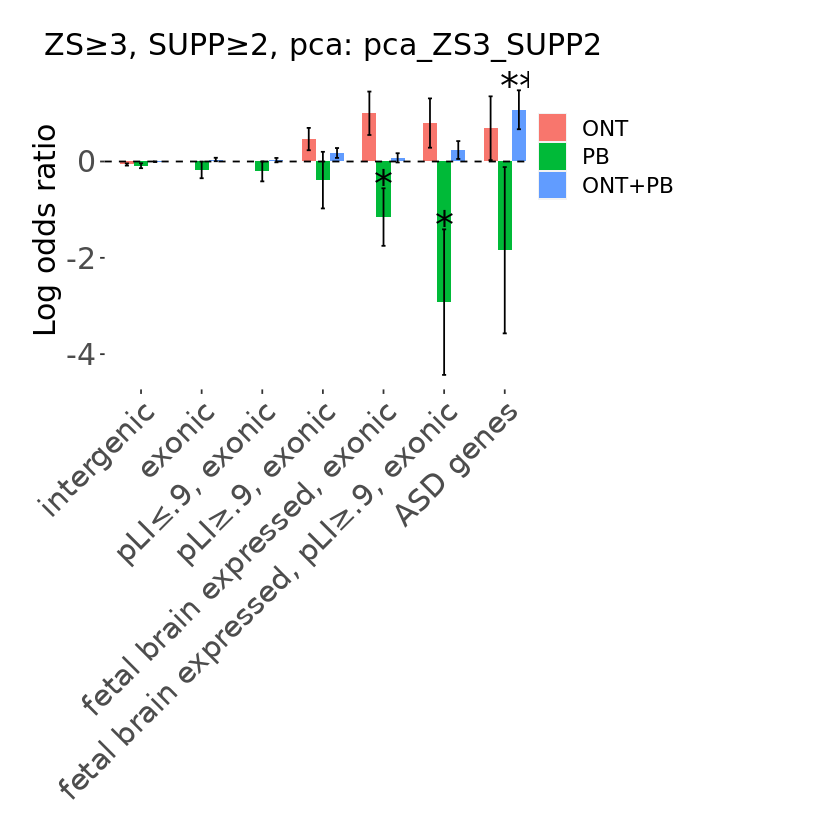

In [17]:
# plot TRs, platform
sub_fts_labels = c('intergenic', 'exonic',
                   'pLI≤.9, exonic', 'pLI≥.9, exonic', 
                   'fetal brain expressed, exonic', 'fetal brain expressed, pLI≥.9, exonic', 
                   'ASD genes')
sub_fts = c('intergenic', 'genic_cds + genic_utr',  
            'LOWPLI_cds + LOWPLI_utr', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr', 
            'FDR_ASD_cds + FDR_ASD_utr')

#sub_fts_labels = c('intergenic', 'exonic',
#                   'pLI≤.9, exonic', 'pLI≥.9, exonic', 
#                   'fetal brain expressed, exonic', 'fetal brain expressed, pLI≥.9, exonic')
#sub_fts = c('intergenic', 'genic_cds + genic_utr',  
#            'LOWPLI_cds + LOWPLI_utr', 'PLIp9_cds + PLIp9_utr', 
#            'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')

fig_base = paste0('TRs_burden_platform_', 'ZS', zs_thr, '_SUPP', supp_thr, '_', pca_suff)
title = paste0('ZS≥',zs_thr, ', ', 'SUPP≥', supp_thr, ', pca: ', pca_suff)

my_data_sub = my_data_tr_all_ont_pb[my_data_tr_all_ont_pb$fts %in% sub_fts,]
my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)

my_data_sub.melt = melt(my_data_sub, id.vars = c('fts', 'fts_labels', 
                                                 'log_ORs_plus', 'log_ORs_minus', 
                                                 'ano_pval', 
                                                 'sum_case_con', 
                                                 'log_ORs_plus_ont', 'log_ORs_minus_ont', 
                                                 'ano_pval_ont', 
                                                 'sum_case_con_ont',
                                                 'log_ORs_plus_pb', 'log_ORs_minus_pb', 
                                                 'ano_pval_pb', 
                                                 'sum_case_con_pb'), 
                        variable.name = 'lor_type', value.name = 'log_ORs')

lor_type_levels = c('log_ORs_ont', 'log_ORs_pb', 'log_ORs')
my_data_sub.melt$lor_type = factor(my_data_sub.melt$lor_type, levels = lor_type_levels)

my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_plus = ifelse(lor_type=='log_ORs', log_ORs_plus,
                                                                             ifelse(lor_type=='log_ORs_ont', log_ORs_plus_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', log_ORs_plus_pb, '.'))))
my_data_sub.melt[,'log_ORs_plus'] <- as.double(my_data_sub.melt[,'log_ORs_plus'])

my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_minus = ifelse(lor_type=='log_ORs', log_ORs_minus,
                                                                             ifelse(lor_type=='log_ORs_ont', log_ORs_minus_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', log_ORs_minus_pb, '.'))))
my_data_sub.melt[,'log_ORs_minus'] <- as.double(my_data_sub.melt[,'log_ORs_minus'])

my_data_sub.melt <- transform(my_data_sub.melt, ano_pval = ifelse(lor_type=='log_ORs', ano_pval,
                                                                             ifelse(lor_type=='log_ORs_ont', ano_pval_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', ano_pval_pb, '.'))))
my_data_sub.melt[,'ano_pval'] <- as.double(my_data_sub.melt[,'ano_pval'])

sig <- sapply(my_data_sub.melt$ano_pval, get_pval_char)
my_data_sub.melt$sig = sig

#my_data_sub.melt

size_txt = 18
size_sig = 8
ylim_min = -0.1
ylim_max = 1.5

fig_name = paste0(dir_fig, fig_base, ".png")

base <- ggplot(my_data_sub.melt, aes(x = fts, y = log_ORs, fill = lor_type, ymin=log_ORs_minus , ymax=log_ORs_plus)) +
  geom_bar(position = position_dodge(width=0.7), stat = "identity", width = 0.7) +
  geom_errorbar(position = position_dodge(width=0.7), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=0.7), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
  labs(y = "Log odds ratio", title = title) +
  theme(axis.text=element_text(size=size_txt),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1., size=size_txt),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size=size_txt),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5, size=size_txt), 
        legend.position = c(1.15, 0.8),
        legend.text = element_text(size=size_txt-5),
        legend.title = element_text(size=size_txt),
        plot.margin = margin(20, 180, 20, 20) # Add margins: top, right, bottom, left (in points)
        ) +
  scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) +
  #scale_fill_discrete(name = 'Subjects', labels = c("combined", "SNV/indel non-carriers"), values = c("red", "green")) + 
  scale_fill_discrete(name = '', labels = c("ONT", "PB", "ONT+PB"))
  #scale_fill_manual(name = 'Subjects', labels = c("combined", "excluding case subjects with dnLOF, dnMIS and InhLOF SNVs/indels"), values=c("khaki", "indianred1")) +

#if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(ylim_min, 2))}
#base <- base + ylim(c(ylim_min, ylim_max))

print(fig_name)
print(base)
ggsave(fig_name, width = 10, height = 8)

[1] "R_clogit/for_publish_v5/TRs_burden_main_ZS3_SUPP2_pca_ZS3_SUPP2.png"


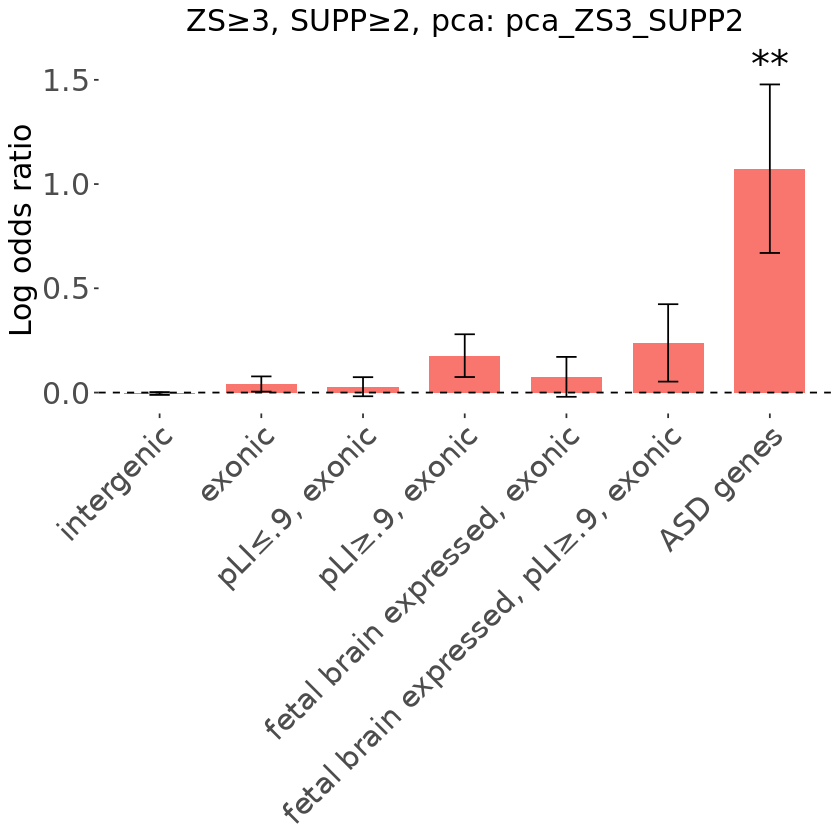

In [18]:
# plot TRs, main
sub_fts_labels = c('intergenic', 'exonic',
                   'pLI≤.9, exonic', 'pLI≥.9, exonic', 
                   'fetal brain expressed, exonic', 'fetal brain expressed, pLI≥.9, exonic', 
                   'ASD genes')
sub_fts = c('intergenic', 'genic_cds + genic_utr',  
            'LOWPLI_cds + LOWPLI_utr', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr', 
            'FDR_ASD_cds + FDR_ASD_utr')

#sub_fts_labels = c('intergenic', 'pLI≤.9, intronic', 'pLI≤.9, exonic', 'pLI≥.9, intronic', 'pLI≥.9, exonic', 
#                   'fetal brain expressed, intronic', 'fetal brain expressed, exonic', 
#                   'fetal brain expressed, pLI≥.9, intronic', 'fetal brain expressed, pLI≥.9, exonic')
#sub_fts = c('intergenic', 'LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr', 'PLIp9_intron', 'PLIp9_cds + PLIp9_utr', 
#            'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 
#            'PLIp9_DEV_BR_GENE_10_intron', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')
fig_base = paste0('TRs_burden_main_', 'ZS', zs_thr, '_SUPP', supp_thr, '_', pca_suff)
title = paste0('ZS≥',zs_thr, ', ', 'SUPP≥', supp_thr, ', pca: ', pca_suff)

my_data_sub = my_data_tr_all_ont_pb[my_data_tr_all_ont_pb$fts %in% sub_fts,]
my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)

sig <- sapply(my_data_sub$ano_pval, get_pval_char)
my_data_sub$sig = sig

#my_data_sub

size_txt = 18
size_sig = 8
ylim_min = -0.1
ylim_max = 1.5

fig_name = paste0(dir_fig, fig_base, ".png")

base <- ggplot(my_data_sub, aes(x = fts, y = log_ORs, fill = 'ref', ymin=log_ORs_minus , ymax=log_ORs_plus)) +
  geom_bar(position = position_dodge(width=0.7), stat = "identity", width = 0.7) +
  geom_errorbar(position = position_dodge(width=0.7), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=0.7), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
  labs(y = "Log odds ratio", title = title) +
  theme(axis.text=element_text(size=size_txt),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1., size=size_txt),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size=size_txt),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5, size=size_txt), 
        legend.position = 'none',
        #legend.position = c(1.15, 0.8),
        #legend.text = element_text(size=size_txt-5),
        #legend.title = element_text(size=size_txt),
        #plot.margin = margin(20, 180, 20, 20) # Add margins: top, right, bottom, left (in points)
        ) +
  scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) 
  #+
  #scale_fill_discrete(name = '', labels = c("ONT", "PB", "ONT+PB"))

#if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(ylim_min, 2))}
#base <- base + ylim(c(ylim_min, ylim_max))

print(fig_name)
print(base)
ggsave(fig_name, width = 10, height = 8)

[1] "no extra covariates......................."
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_PLIp9_intron_SUPP2_Q"
[1] "count_ZS3_LOWPLI_intron_SUPP2_Q"
[1] "count_ZS3_FDR_ASD_cds_SUPP2_Q" "count_ZS3_FDR_ASD_utr_SUPP2_Q"
[1] "count_ZS3_FDR_ASD_intron_SUPP2_Q"
[1] "ORs:"
 [1] 1.298051 1.154994 1.200357 1.066198 1.009315 1.012872 1.008092 1.001345
 [9] 2.246184 1.089671
[1] "ORs_plus:"
 [1] 1.671243 1.324360 1.378174 1.131955 1.041061 1.033319 1.020683 1.003556
 [9] 4.051763 1.202171
[1] "ORs_minus:"
 [1] 1.0081933 1.0072872 1.0454820 1.0042606 0.9785364 0.9928297 0.9956568
 [8] 0.9991396 1.2452215 0.9876984
[1]

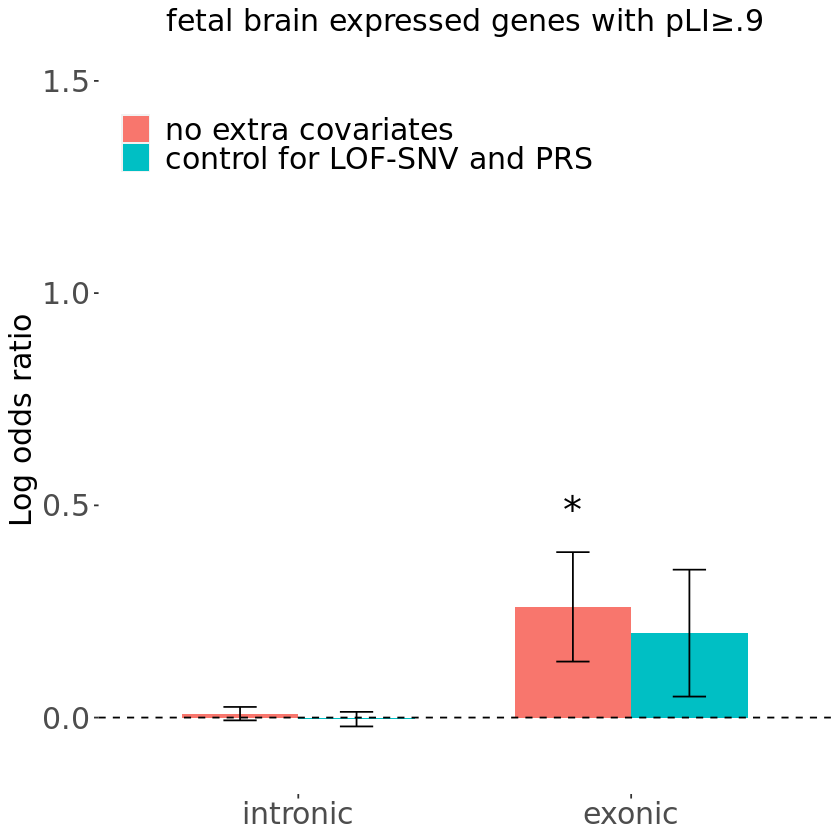

[1] "R_clogit/for_publish_v3/TRs_PLI_ZS3_SUPP2_Q.png"


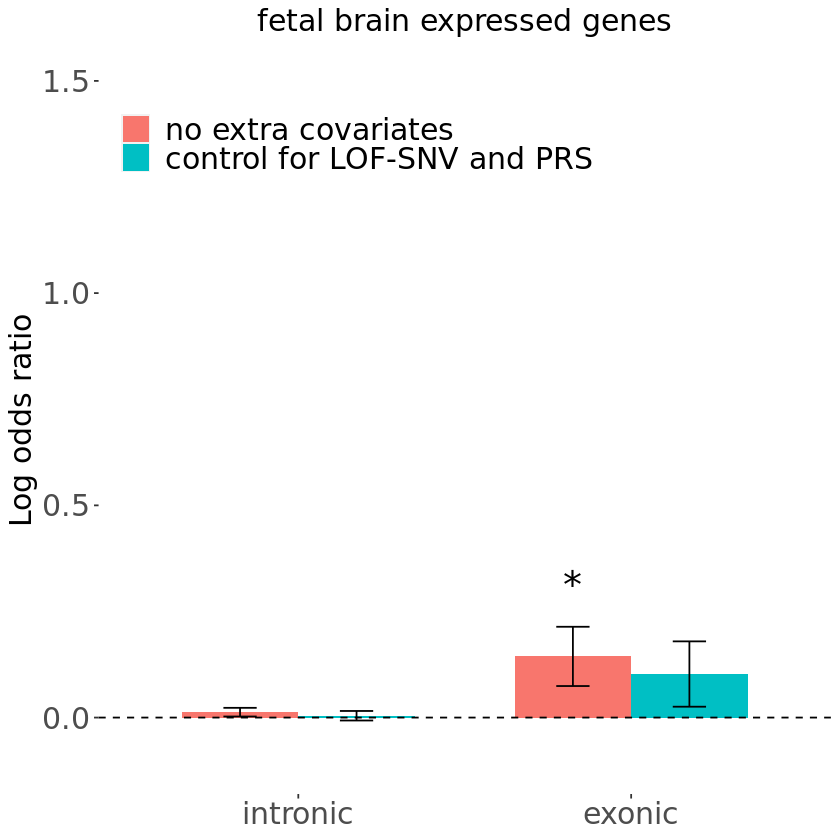

[1] "R_clogit/for_publish_v3/TRs_LOWPLI_ZS3_SUPP2_Q.png"


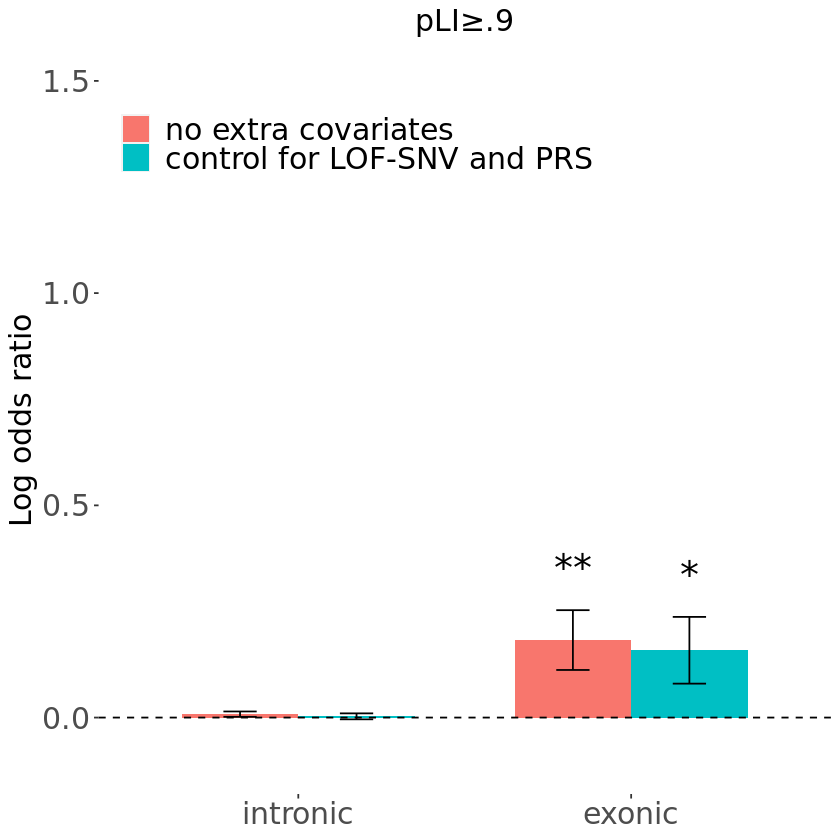

[1] "R_clogit/for_publish_v3/TRs_FDR_ASD_ZS3_SUPP2_Q.png"


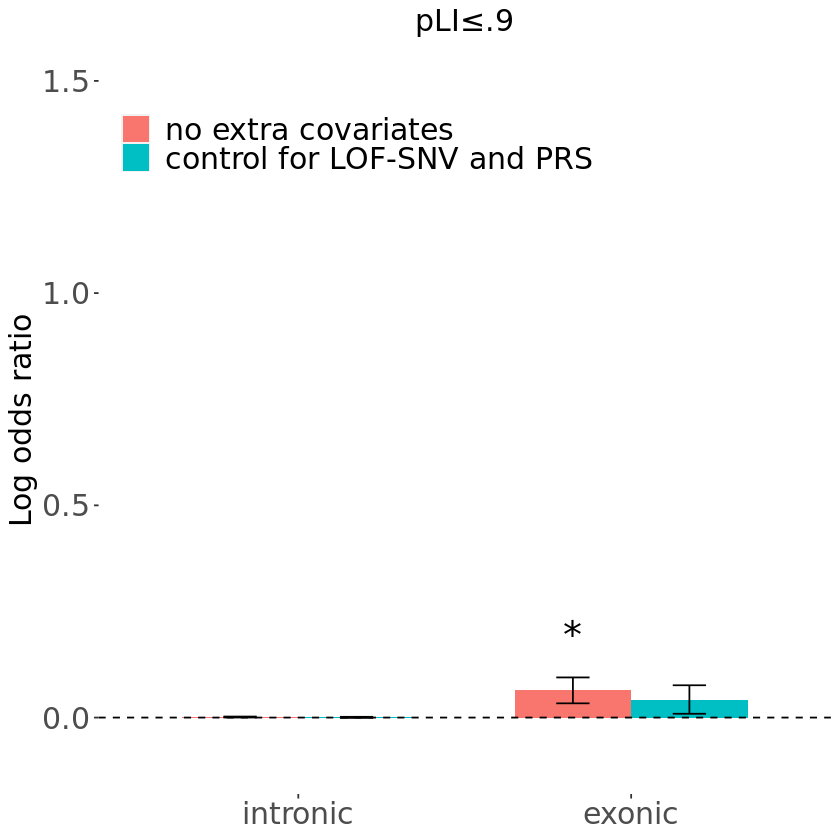

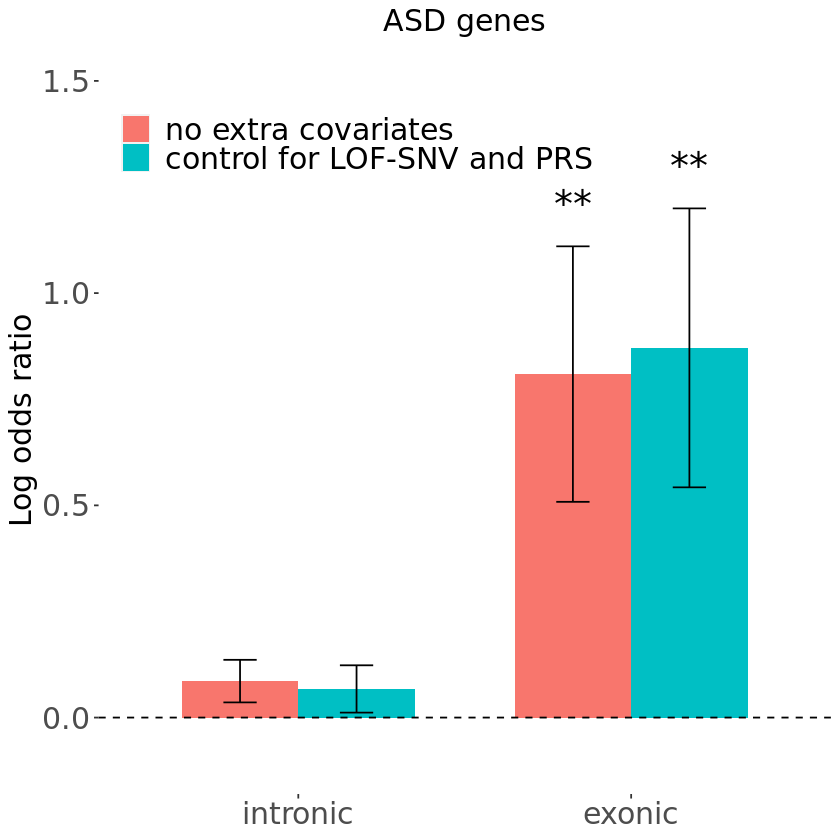

In [9]:
### TRs
PRINT_INFO = TRUE
#PRINT_INFO = FALSE

zs_thr = 3
supp_thr = 2
#supp_thr = 3
q_suf = '_Q'

null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + 
                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in trs_fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
                                     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

### with LOF-SNV and PRS covariates...
print('with LOF-SNV and PRS covariates.......................')

null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +
                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')

ORs_ncar = c()
ORs_plus_ncar = c()
ORs_minus_ncar = c()
log_ORs_ncar = c()
log_ORs_plus_ncar = c()
log_ORs_minus_ncar = c()
pvals_ncar = c()
ano_pvals_ncar = c()
sum_cases_ncar = c()
sum_controls_ncar = c()
for (trs_ft in trs_fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases_ncar = c(sum_cases_ncar, sum_case)
    sum_controls_ncar = c(sum_controls_ncar, sum_control)
        
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +
                                     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs_ncar = c(ORs_ncar, OR)
    ORs_plus_ncar = c(ORs_plus_ncar, OR_plus)
    ORs_minus_ncar = c(ORs_minus_ncar, OR_minus)
    log_ORs_ncar = c(log_ORs_ncar, log_OR)
    log_ORs_plus_ncar = c(log_ORs_plus_ncar, log_OR_plus)
    log_ORs_minus_ncar = c(log_ORs_minus_ncar, log_OR_minus)
    pvals_ncar = c(pvals_ncar, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals_ncar = c(ano_pvals_ncar, ano_pval)
}

sum_case_controls_ncar = paste(as.character(sum_cases_ncar), as.character(sum_controls_ncar), sep='/')

if (PRINT_INFO) {
    print('ORs_ncar:')
    print(ORs_ncar)
    print('ORs_plus_ncar:')
    print(ORs_plus_ncar)
    print('ORs_minus_ncar:')
    print(ORs_minus_ncar)
    print('log_ORs_ncar:')
    print(log_ORs_ncar)
    print('log_ORs_plus_ncar:')
    print(log_ORs_plus_ncar)
    print('log_ORs_minus_ncar:')
    print(log_ORs_minus_ncar)
    print('pvals_ncar:')
    print(pvals_ncar)
    print('ano_pvals_ncar:')
    print(ano_pvals_ncar)
    print('sum_cases_ncar:')
    print(sum_cases_ncar)
    print('sum_controls_ncar:')
    print(sum_controls_ncar)
    print('sum_case_controls_ncar:')
    print(sum_case_controls_ncar)
}

my_data = data.frame('fts' = trs_fts, 'fts_labels' = trs_fts_labels, 
                     'log_ORs_comb' = log_ORs, 'log_ORs_plus_comb' = log_ORs_plus, 'log_ORs_minus_comb' = log_ORs_minus, 
                     'ano_pval_comb' = ano_pvals, 
                     'sum_case_con_comb' = sum_case_controls, 
                     'log_ORs_ncar' = log_ORs_ncar, 'log_ORs_plus_ncar' = log_ORs_plus_ncar, 'log_ORs_minus_ncar' = log_ORs_minus_ncar, 
                     'ano_pval_ncar' = ano_pvals_ncar, 
                     'sum_case_con_ncar' = sum_case_controls_ncar)
#print(my_data)

this_cols = c('fts_labels', 
              'log_ORs_comb', 'log_ORs_plus_comb', 'log_ORs_minus_comb', 'ano_pval_comb', 
              'log_ORs_ncar', 'log_ORs_plus_ncar', 'log_ORs_minus_ncar', 'ano_pval_ncar')
# be carefull there are repeated names for the columns in the new column names. this may cause
# problems when accessing the columns
new_cols = c('Category', 
             'log OR, no extra cov.', 'upper 95% CI', 'lower 95% CI', 'ANOVA p-value', 
             'log OR, with LOF-SNV and PRS cov.', 'upper 95% CI', 'lower 95% CI', 'ANOVA p-value')
this_data_out = my_data[this_cols]
# formating the columns with number of digits
for (i_col in 2:length(this_cols)) {
    this_col = this_cols[i_col]
    this_data_out[this_col] = format(this_data_out[this_col], digits = 4, nsmall = 2)
}
colnames(this_data_out) <- new_cols
print(this_data_out)
file_out = paste0(dir_fig, 'burden_tests_table_trs.tsv')
print(file_out)
write.table(this_data_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

sub_fts_labels = c('intronic', 'exonic')
sub_fts_1 = c('PLIp9_DEV_BR_GENE_10_intron', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')
title_1 = 'fetal brain expressed genes with pLI≥.9'
fig_base_1 = 'devBrainPLI'
sub_fts_2 = c('DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr')
title_2 = 'fetal brain expressed genes'
fig_base_2 = 'devBrain'
sub_fts_3 = c('PLIp9_intron', 'PLIp9_cds + PLIp9_utr')
title_3 = 'pLI≥.9'
fig_base_3 = 'PLI'
sub_fts_4 = c('LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr')
title_4 = 'pLI≤.9'
fig_base_4 = 'LOWPLI'
sub_fts_5 = c('FDR_ASD_intron', 'FDR_ASD_cds + FDR_ASD_utr')
title_5 = 'ASD genes'
fig_base_5 = 'FDR_ASD'
#sub_fts = c('GNOCCHI_MAX_3_intron', 'GNOCCHI_MAX_3_utr', 'GNOCCHI_MAX_3_cds', 'GNOCCHI_MAX_3_?')

sub_flts_list = list(sub_fts_1, sub_fts_2, sub_fts_3, sub_fts_4, sub_fts_5)
title_list = list(title_1, title_2, title_3, title_4, title_5)
fig_base_list = list(fig_base_1, fig_base_2, fig_base_3, fig_base_4, fig_base_5)

for (i_plot in 1:length(sub_flts_list)) {
#for (i_plot in 1:1) {
    sub_fts = sub_flts_list[[i_plot]]
    title = title_list[[i_plot]]
    fig_base = fig_base_list[[i_plot]]
    fig_name = paste0(dir_fig, 'TRs_', fig_base, '_ZS', zs_thr, '_SUPP', supp_thr, q_suf, ".png")

    my_data_sub = my_data[my_data$fts %in% sub_fts,]
    my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)
    #print('subset df:')
    #print(my_data_sub)

    my_data_sub.melt = melt(my_data_sub, id.vars = c('fts', 'fts_labels', 
                                                     'log_ORs_plus_comb', 'log_ORs_minus_comb', 
                                                     'ano_pval_comb', 
                                                     'sum_case_con_comb', 
                                                     'log_ORs_plus_ncar', 'log_ORs_minus_ncar', 
                                                     'ano_pval_ncar', 
                                                     'sum_case_con_ncar'), 
                            variable.name = 'comb_ncar', value.name = 'log_ORs')

    my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_plus = ifelse(comb_ncar=='log_ORs_comb', log_ORs_plus_comb, log_ORs_plus_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_minus = ifelse(comb_ncar=='log_ORs_comb', log_ORs_minus_comb, log_ORs_minus_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, ano_pval = ifelse(comb_ncar=='log_ORs_comb', ano_pval_comb, ano_pval_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, sum_case_con = ifelse(comb_ncar=='log_ORs_comb', sum_case_con_comb, sum_case_con_ncar))

    sig <- sapply(my_data_sub.melt$ano_pval, get_pval_char)
    my_data_sub.melt$sig = sig

    #print('my_data_sub.melt:')
    #print(my_data_sub.melt)

    size_txt = 18
    size_sig = 8
    ylim_min = -0.1
    ylim_max = 1.5

    #geom_text(aes(label = tr_ntr), position=position_dodge(width=0.9), angle=90, hjust=0, vjust=0.5, size=2) +
    #plot.margin = margin(t = 1.5, l = 1.5, r = 1, b = 1, "cm"),

    base <- ggplot(my_data_sub.melt, aes(x = fts, y = log_ORs, fill = comb_ncar, ymin=log_ORs_minus , ymax=log_ORs_plus)) +
      geom_bar(position = position_dodge(width=0.7), stat = "identity", width = 0.7) +
      geom_errorbar(position = position_dodge(width=0.7), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = 0.2) +
      geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
      geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=0.7), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
      labs(y = "Log odds ratio", title = title) +
      theme(axis.text=element_text(size=size_txt),
            axis.text.x = element_text(angle = 0, vjust = 1, hjust=0.5, size=size_txt),
            axis.title.x = element_blank(),
            axis.title.y = element_text(size=size_txt),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5, size=size_txt), 
            legend.position = c(0.35, 0.9),
            legend.text = element_text(size=size_txt),
            legend.title = element_text(size=size_txt)
            ) +
      scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) +
      #scale_fill_discrete(name = 'Subjects', labels = c("combined", "SNV/indel non-carriers"), values = c("red", "green")) + 
      scale_fill_discrete(name = '', labels = c("no extra covariates", "control for LOF-SNV and PRS"))
      #scale_fill_manual(name = 'Subjects', labels = c("combined", "excluding case subjects with dnLOF, dnMIS and InhLOF SNVs/indels"), values=c("khaki", "indianred1")) +

    #if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(-3, 3))}
    base <- base + ylim(c(ylim_min, ylim_max))

    print(fig_name)
    print(base)
    ggsave(fig_name, width = 10, height = 6)
}

In [6]:
# write burden score counts
zs_thr = 3
supp_thr = 2
q_suf = '_Q'

cols_out = c('fid','iid','Phenotype','sex','MEAN_COVERAGE','Platform','rel','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
             'count_dnlof_inhlof','PRS_ASD_Z')
df_out = df_main[cols_out]

for (i_ft in 1:length(fts)) {
    ft = fts[i_ft]
    col_out_base = fts_col_names[i_ft]
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    svs_tmp = paste0('count_', ft_tmp) # add count_
    trs_tmp = paste0('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf) # add count_

    col_out = paste0('svs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in svs_tmp) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }

    col_out = paste0('trs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in trs_tmp) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }

    col_out = paste0('svs_trs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in c(svs_tmp, trs_tmp)) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }
}

for (i_ft in (length(fts)+1):length(trs_fts)) {
    ft = trs_fts[i_ft]
    col_out_base = trs_fts_col_names[i_ft]
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    trs_tmp = paste0('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf) # add count_

    col_out = paste0('trs_', col_out_base)
    df_out[col_out] = 0
    for (ft_ in trs_tmp) {
        df_out[col_out] = df_out[col_out] + df_main[ft_]
    }
}

df_out
file_out = paste0(dir_fig, 'burden_tests_table_counts.tsv')
print(file_out)
write.table(df_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

fid,iid,Phenotype,sex,MEAN_COVERAGE,Platform,rel,PC1,PC2,PC3,⋯,trs_fetal_brain_genes_intronic,svs_trs_fetal_brain_genes_intronic,svs_pli_genes_intronic,trs_pli_genes_intronic,svs_trs_pli_genes_intronic,svs_lowpli_genes_intronic,trs_lowpli_genes_intronic,svs_trs_lowpli_genes_intronic,trs_asd_genes_exonic,trs_asd_genes_intronic
<chr>,<chr>,<int>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F0001,REACH000001,1,Male,10.15,ONT,C,0.008627126,-0.005607061,-0.003588309,⋯,104,137,48,193,241,276,1000,1276,3,14
F0026,REACH000026,1,Male,3.22,PB,C,0.095363540,-0.045229620,-0.019471550,⋯,1,14,43,2,45,257,21,278,0,0
F0058,REACH000058,1,Male,6.19,PB,C,0.002421759,-0.009216429,-0.007762021,⋯,32,51,32,43,75,194,276,470,0,7
F0065,REACH000065,1,Male,1.22,PB,C,0.252773800,0.107932900,0.199377900,⋯,0,24,38,1,39,233,9,242,0,0
F0078,REACH000086,1,Male,2.70,PB,C,0.044785250,0.038064880,0.054606420,⋯,16,39,36,17,53,142,100,242,0,2
F0078,REACH000089,1,Female,3.27,PB,C,0.049879690,0.047204300,0.069404520,⋯,11,24,25,18,43,156,130,286,0,2
F0081,REACH000092,1,Female,4.89,PB,C,-0.028510680,-0.001001894,-0.001920863,⋯,18,39,27,30,57,213,227,440,0,4
F0081,REACH000095,0,Female,5.12,PB,C,-0.030440730,-0.002736118,-0.006993734,⋯,10,32,31,23,54,205,232,437,0,3
F0083,REACH000097,1,Male,5.82,PB,C,0.095793110,0.052887850,0.100821100,⋯,28,65,45,46,91,277,283,560,0,0


[1] "R_clogit/for_publish_v3/burden_tests_table_counts.tsv"


[1] "no extra covariates......................."
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_ZS3_PLIp9_intron_SUPP2_Q"
[1] "count_ZS3_LOWPLI_intron_SUPP2_Q"
[1] "count_ZS3_FDR_ASD_cds_SUPP2_Q" "count_ZS3_FDR_ASD_utr_SUPP2_Q"
[1] "count_ZS3_FDR_ASD_intron_SUPP2_Q"
[1] "ORs:"
 [1] 1.298051 1.154994 1.200357 1.066198 1.009315 1.012872 1.008092 1.001345
 [9] 2.246184 1.089671
[1] "ORs_plus:"
 [1] 1.671243 1.324360 1.378174 1.131955 1.041061 1.033319 1.020683 1.003556
 [9] 4.051763 1.202171
[1] "ORs_minus:"
 [1] 1.0081933 1.0072872 1.0454820 1.0042606 0.9785364 0.9928297 0.9956568
 [8] 0.9991396 1.2452215 0.9876984
[1]

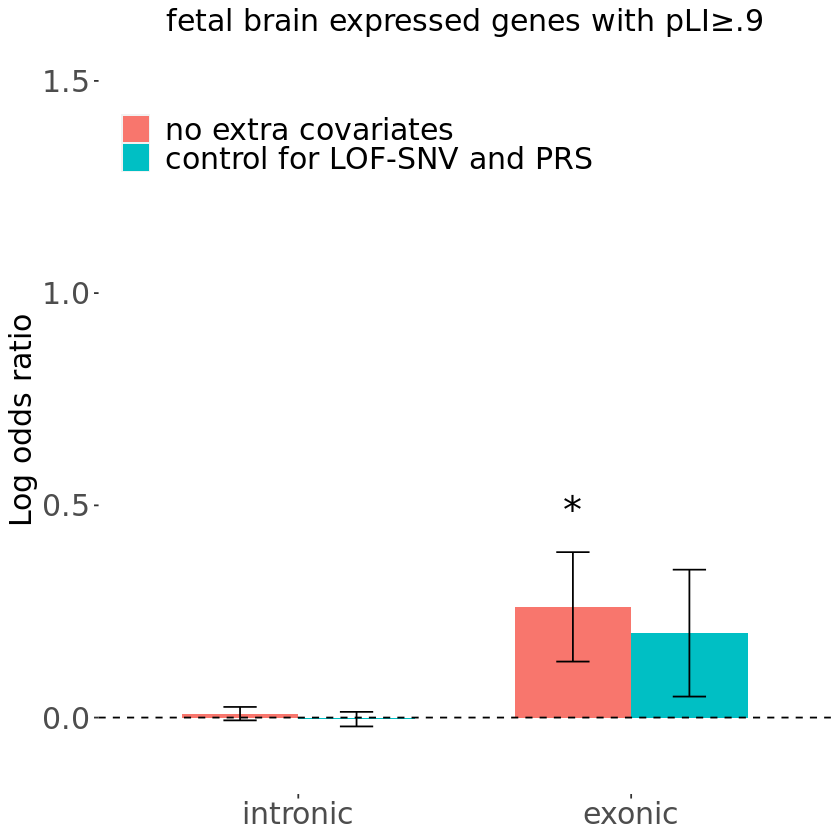

[1] "R_clogit/for_publish_v3/TRs_PLI_ZS3_SUPP2_Q.png"


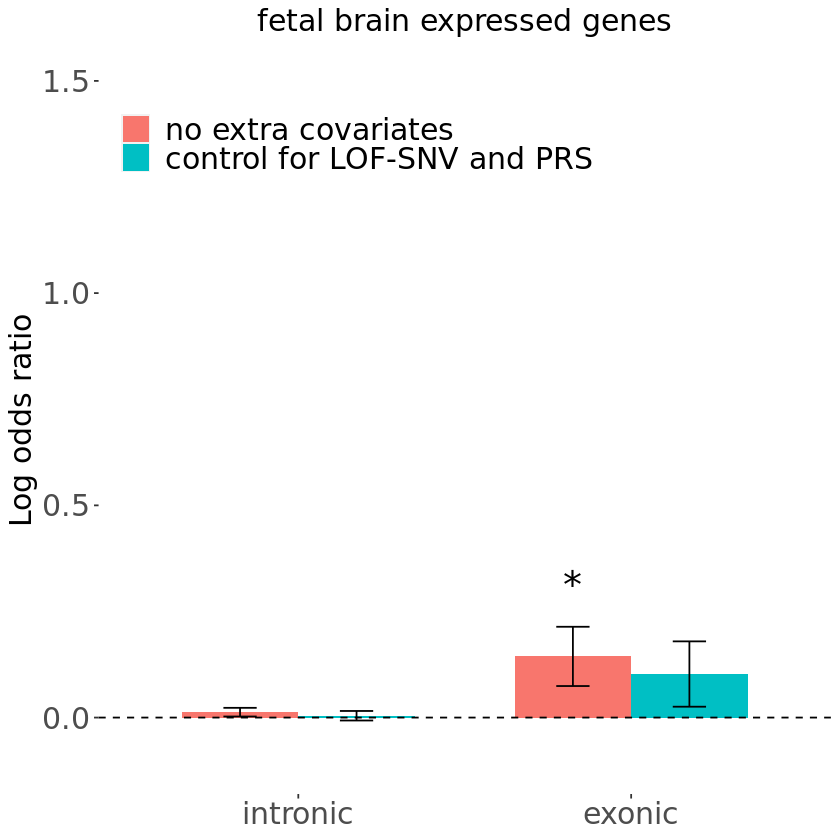

[1] "R_clogit/for_publish_v3/TRs_LOWPLI_ZS3_SUPP2_Q.png"


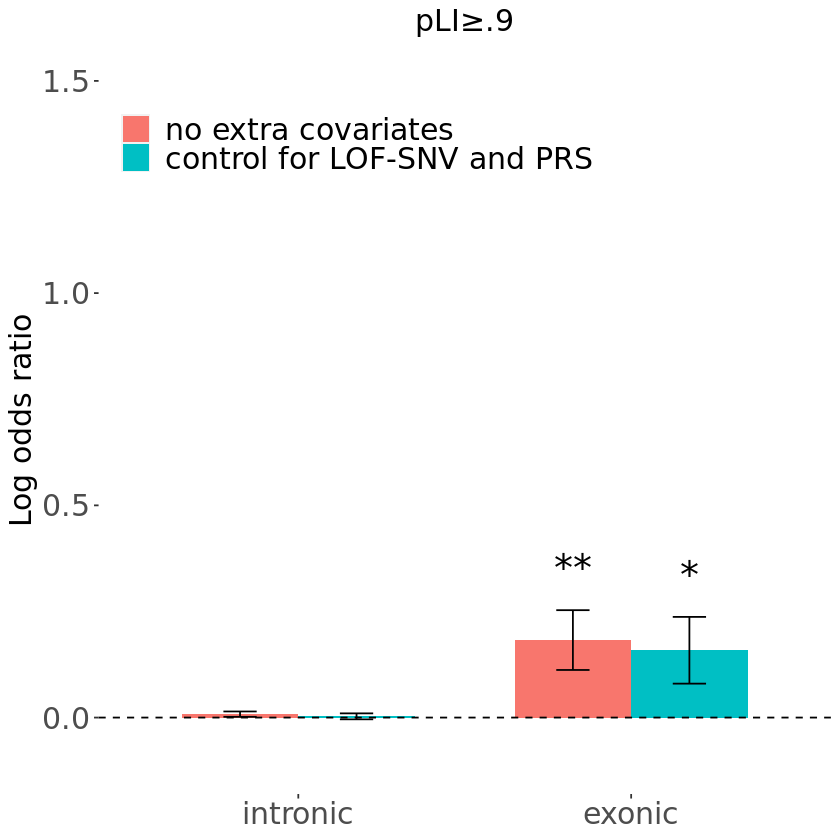

[1] "R_clogit/for_publish_v3/TRs_FDR_ASD_ZS3_SUPP2_Q.png"


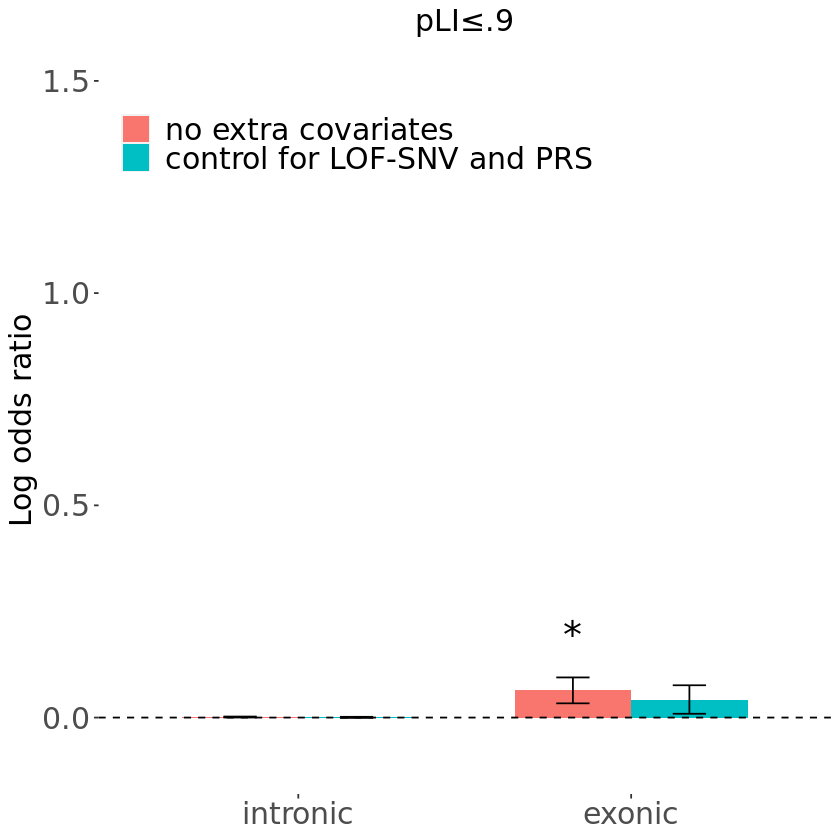

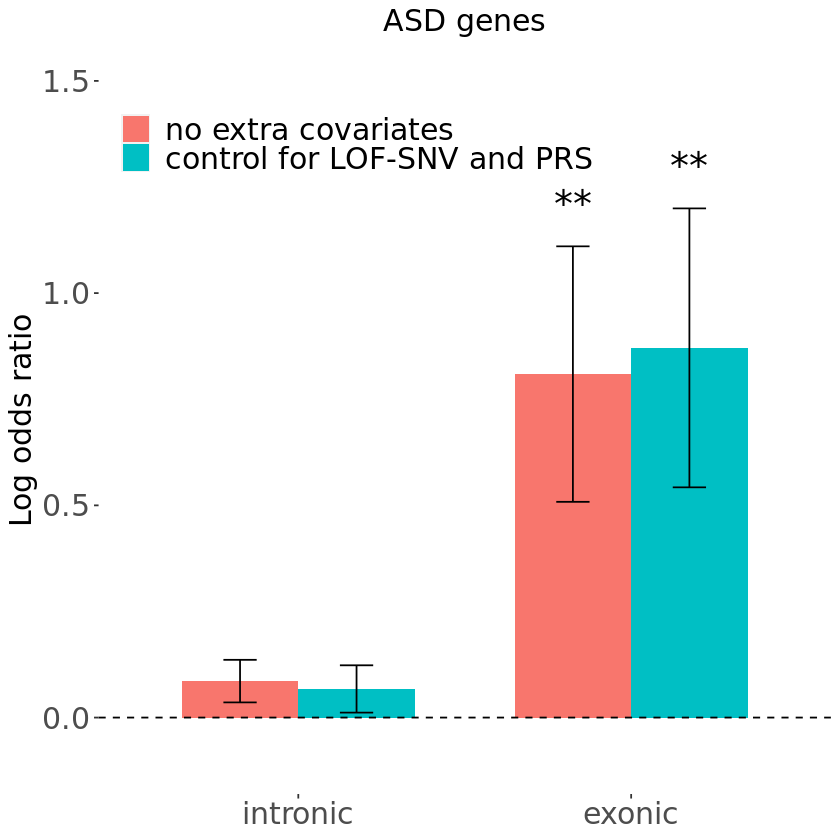

In [9]:
### TRs
PRINT_INFO = TRUE
#PRINT_INFO = FALSE

zs_thr = 3
supp_thr = 2
#supp_thr = 3
q_suf = '_Q'

null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + 
                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in trs_fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
                                     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

### with LOF-SNV and PRS covariates...
print('with LOF-SNV and PRS covariates.......................')

null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +
                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')

ORs_ncar = c()
ORs_plus_ncar = c()
ORs_minus_ncar = c()
log_ORs_ncar = c()
log_ORs_plus_ncar = c()
log_ORs_minus_ncar = c()
pvals_ncar = c()
ano_pvals_ncar = c()
sum_cases_ncar = c()
sum_controls_ncar = c()
for (trs_ft in trs_fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases_ncar = c(sum_cases_ncar, sum_case)
    sum_controls_ncar = c(sum_controls_ncar, sum_control)
        
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +
                                     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs_ncar = c(ORs_ncar, OR)
    ORs_plus_ncar = c(ORs_plus_ncar, OR_plus)
    ORs_minus_ncar = c(ORs_minus_ncar, OR_minus)
    log_ORs_ncar = c(log_ORs_ncar, log_OR)
    log_ORs_plus_ncar = c(log_ORs_plus_ncar, log_OR_plus)
    log_ORs_minus_ncar = c(log_ORs_minus_ncar, log_OR_minus)
    pvals_ncar = c(pvals_ncar, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals_ncar = c(ano_pvals_ncar, ano_pval)
}

sum_case_controls_ncar = paste(as.character(sum_cases_ncar), as.character(sum_controls_ncar), sep='/')

if (PRINT_INFO) {
    print('ORs_ncar:')
    print(ORs_ncar)
    print('ORs_plus_ncar:')
    print(ORs_plus_ncar)
    print('ORs_minus_ncar:')
    print(ORs_minus_ncar)
    print('log_ORs_ncar:')
    print(log_ORs_ncar)
    print('log_ORs_plus_ncar:')
    print(log_ORs_plus_ncar)
    print('log_ORs_minus_ncar:')
    print(log_ORs_minus_ncar)
    print('pvals_ncar:')
    print(pvals_ncar)
    print('ano_pvals_ncar:')
    print(ano_pvals_ncar)
    print('sum_cases_ncar:')
    print(sum_cases_ncar)
    print('sum_controls_ncar:')
    print(sum_controls_ncar)
    print('sum_case_controls_ncar:')
    print(sum_case_controls_ncar)
}

my_data = data.frame('fts' = trs_fts, 'fts_labels' = trs_fts_labels, 
                     'log_ORs_comb' = log_ORs, 'log_ORs_plus_comb' = log_ORs_plus, 'log_ORs_minus_comb' = log_ORs_minus, 
                     'ano_pval_comb' = ano_pvals, 
                     'sum_case_con_comb' = sum_case_controls, 
                     'log_ORs_ncar' = log_ORs_ncar, 'log_ORs_plus_ncar' = log_ORs_plus_ncar, 'log_ORs_minus_ncar' = log_ORs_minus_ncar, 
                     'ano_pval_ncar' = ano_pvals_ncar, 
                     'sum_case_con_ncar' = sum_case_controls_ncar)
#print(my_data)

this_cols = c('fts_labels', 
              'log_ORs_comb', 'log_ORs_plus_comb', 'log_ORs_minus_comb', 'ano_pval_comb', 
              'log_ORs_ncar', 'log_ORs_plus_ncar', 'log_ORs_minus_ncar', 'ano_pval_ncar')
# be carefull there are repeated names for the columns in the new column names. this may cause
# problems when accessing the columns
new_cols = c('Category', 
             'log OR, no extra cov.', 'upper 95% CI', 'lower 95% CI', 'ANOVA p-value', 
             'log OR, with LOF-SNV and PRS cov.', 'upper 95% CI', 'lower 95% CI', 'ANOVA p-value')
this_data_out = my_data[this_cols]
# formating the columns with number of digits
for (i_col in 2:length(this_cols)) {
    this_col = this_cols[i_col]
    this_data_out[this_col] = format(this_data_out[this_col], digits = 4, nsmall = 2)
}
colnames(this_data_out) <- new_cols
print(this_data_out)
file_out = paste0(dir_fig, 'burden_tests_table_trs.tsv')
print(file_out)
write.table(this_data_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

sub_fts_labels = c('intronic', 'exonic')
sub_fts_1 = c('PLIp9_DEV_BR_GENE_10_intron', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')
title_1 = 'fetal brain expressed genes with pLI≥.9'
fig_base_1 = 'devBrainPLI'
sub_fts_2 = c('DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr')
title_2 = 'fetal brain expressed genes'
fig_base_2 = 'devBrain'
sub_fts_3 = c('PLIp9_intron', 'PLIp9_cds + PLIp9_utr')
title_3 = 'pLI≥.9'
fig_base_3 = 'PLI'
sub_fts_4 = c('LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr')
title_4 = 'pLI≤.9'
fig_base_4 = 'LOWPLI'
sub_fts_5 = c('FDR_ASD_intron', 'FDR_ASD_cds + FDR_ASD_utr')
title_5 = 'ASD genes'
fig_base_5 = 'FDR_ASD'
#sub_fts = c('GNOCCHI_MAX_3_intron', 'GNOCCHI_MAX_3_utr', 'GNOCCHI_MAX_3_cds', 'GNOCCHI_MAX_3_?')

sub_flts_list = list(sub_fts_1, sub_fts_2, sub_fts_3, sub_fts_4, sub_fts_5)
title_list = list(title_1, title_2, title_3, title_4, title_5)
fig_base_list = list(fig_base_1, fig_base_2, fig_base_3, fig_base_4, fig_base_5)

for (i_plot in 1:length(sub_flts_list)) {
#for (i_plot in 1:1) {
    sub_fts = sub_flts_list[[i_plot]]
    title = title_list[[i_plot]]
    fig_base = fig_base_list[[i_plot]]
    fig_name = paste0(dir_fig, 'TRs_', fig_base, '_ZS', zs_thr, '_SUPP', supp_thr, q_suf, ".png")

    my_data_sub = my_data[my_data$fts %in% sub_fts,]
    my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)
    #print('subset df:')
    #print(my_data_sub)

    my_data_sub.melt = melt(my_data_sub, id.vars = c('fts', 'fts_labels', 
                                                     'log_ORs_plus_comb', 'log_ORs_minus_comb', 
                                                     'ano_pval_comb', 
                                                     'sum_case_con_comb', 
                                                     'log_ORs_plus_ncar', 'log_ORs_minus_ncar', 
                                                     'ano_pval_ncar', 
                                                     'sum_case_con_ncar'), 
                            variable.name = 'comb_ncar', value.name = 'log_ORs')

    my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_plus = ifelse(comb_ncar=='log_ORs_comb', log_ORs_plus_comb, log_ORs_plus_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_minus = ifelse(comb_ncar=='log_ORs_comb', log_ORs_minus_comb, log_ORs_minus_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, ano_pval = ifelse(comb_ncar=='log_ORs_comb', ano_pval_comb, ano_pval_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, sum_case_con = ifelse(comb_ncar=='log_ORs_comb', sum_case_con_comb, sum_case_con_ncar))

    sig <- sapply(my_data_sub.melt$ano_pval, get_pval_char)
    my_data_sub.melt$sig = sig

    #print('my_data_sub.melt:')
    #print(my_data_sub.melt)

    size_txt = 18
    size_sig = 8
    ylim_min = -0.1
    ylim_max = 1.5

    #geom_text(aes(label = tr_ntr), position=position_dodge(width=0.9), angle=90, hjust=0, vjust=0.5, size=2) +
    #plot.margin = margin(t = 1.5, l = 1.5, r = 1, b = 1, "cm"),

    base <- ggplot(my_data_sub.melt, aes(x = fts, y = log_ORs, fill = comb_ncar, ymin=log_ORs_minus , ymax=log_ORs_plus)) +
      geom_bar(position = position_dodge(width=0.7), stat = "identity", width = 0.7) +
      geom_errorbar(position = position_dodge(width=0.7), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = 0.2) +
      geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
      geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=0.7), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
      labs(y = "Log odds ratio", title = title) +
      theme(axis.text=element_text(size=size_txt),
            axis.text.x = element_text(angle = 0, vjust = 1, hjust=0.5, size=size_txt),
            axis.title.x = element_blank(),
            axis.title.y = element_text(size=size_txt),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5, size=size_txt), 
            legend.position = c(0.35, 0.9),
            legend.text = element_text(size=size_txt),
            legend.title = element_text(size=size_txt)
            ) +
      scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) +
      #scale_fill_discrete(name = 'Subjects', labels = c("combined", "SNV/indel non-carriers"), values = c("red", "green")) + 
      scale_fill_discrete(name = '', labels = c("no extra covariates", "control for LOF-SNV and PRS"))
      #scale_fill_manual(name = 'Subjects', labels = c("combined", "excluding case subjects with dnLOF, dnMIS and InhLOF SNVs/indels"), values=c("khaki", "indianred1")) +

    #if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(-3, 3))}
    base <- base + ylim(c(ylim_min, ylim_max))

    print(fig_name)
    print(base)
    ggsave(fig_name, width = 10, height = 6)
}

[1] "no extra covariates......................."
[1] "count_PLIp9_DEV_BR_GENE_10_cds"            
[2] "count_PLIp9_DEV_BR_GENE_10_utr"            
[3] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[4] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_DEV_BR_GENE_10_cds"            
[2] "count_DEV_BR_GENE_10_utr"            
[3] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[4] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_PLIp9_cds"             "count_PLIp9_utr"            
[3] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_LOWPLI_cds"             "count_LOWPLI_utr"            
[3] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_PLIp9_DEV_BR_GENE_10_intron"            
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_DEV_BR_GENE_10_intron"            
[2] "count_ZS3_DEV_BR_GENE_10_intron_SUPP2_Q"
[1] "count_PLIp9_intron"             "count_ZS3_PLIp9_intron_SUPP2_Q"
[1] "count_LOWPLI_intron"             "count_ZS3_LOWPLI_i

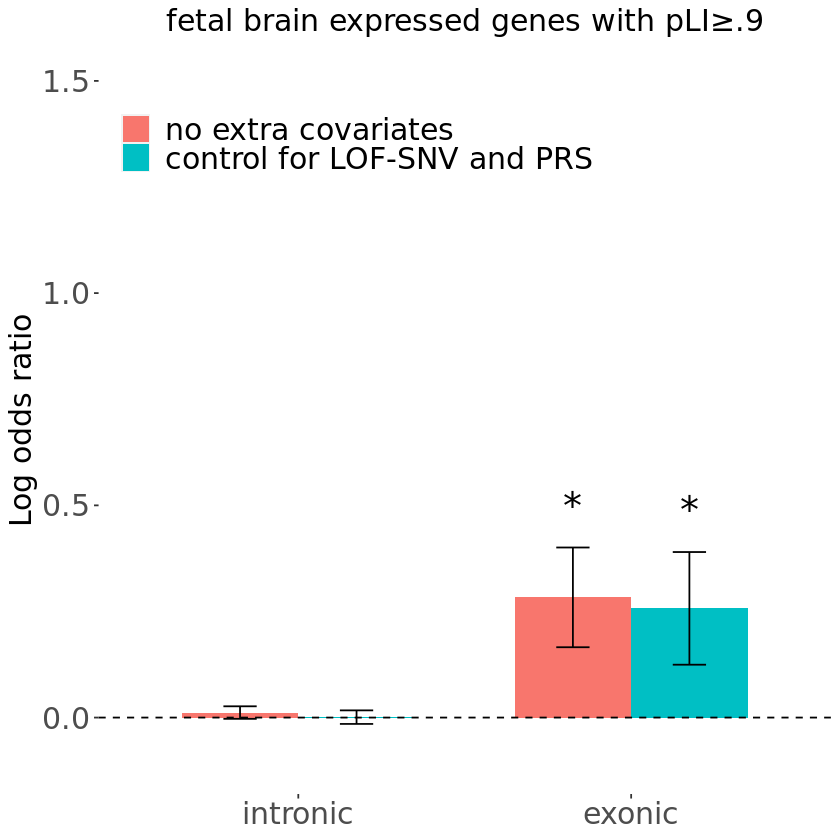

[1] "R_clogit/for_publish_v3/combined_SVs_TRs_PLI_SQ70.png"


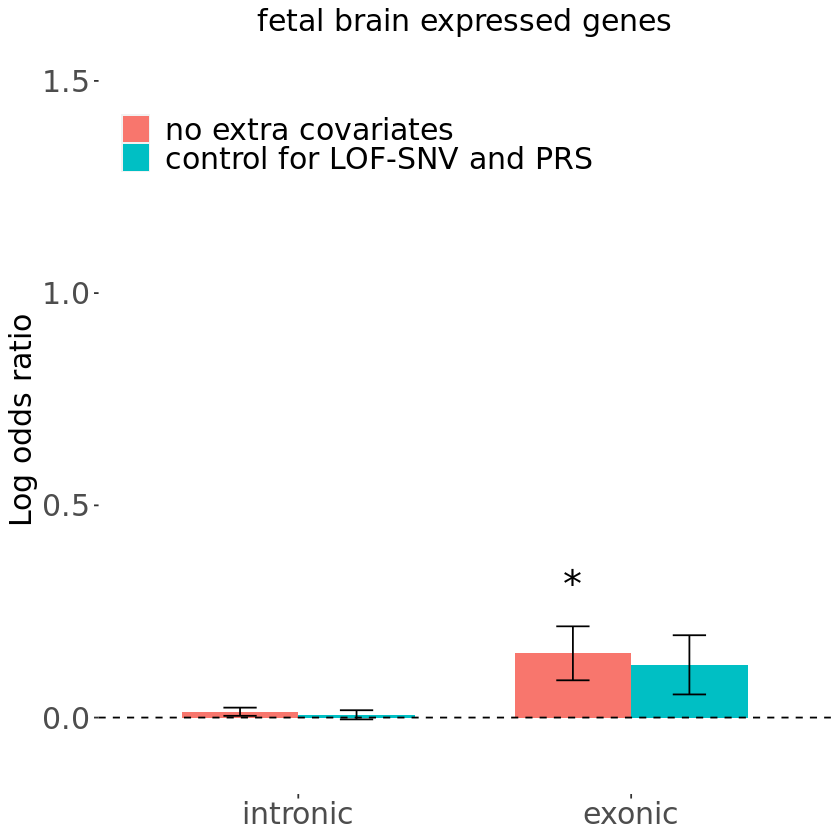

[1] "R_clogit/for_publish_v3/combined_SVs_TRs_LOWPLI_SQ70.png"


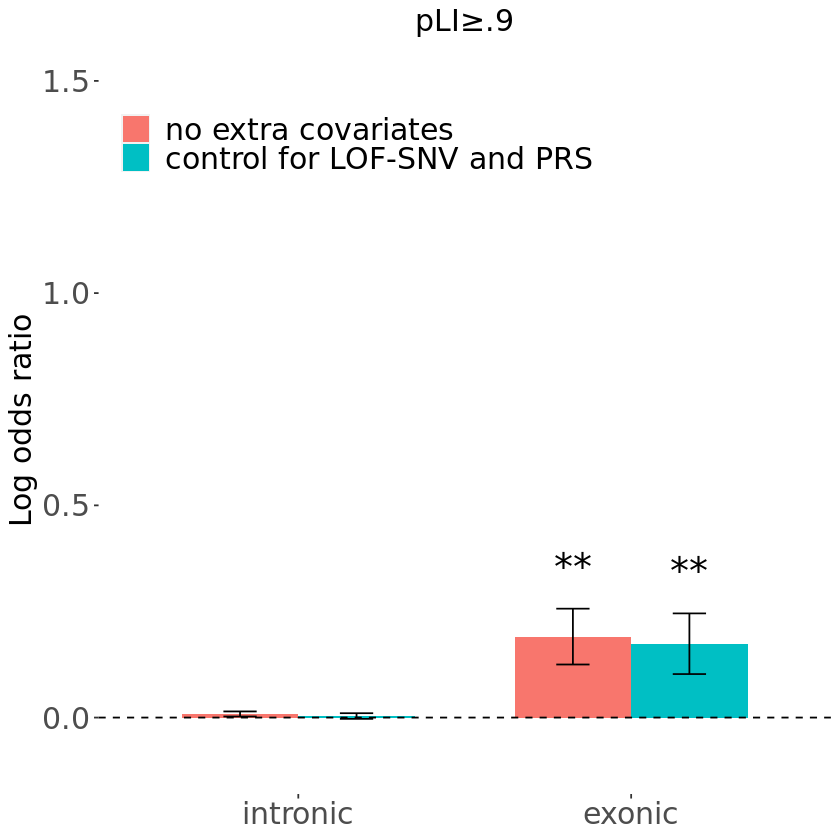

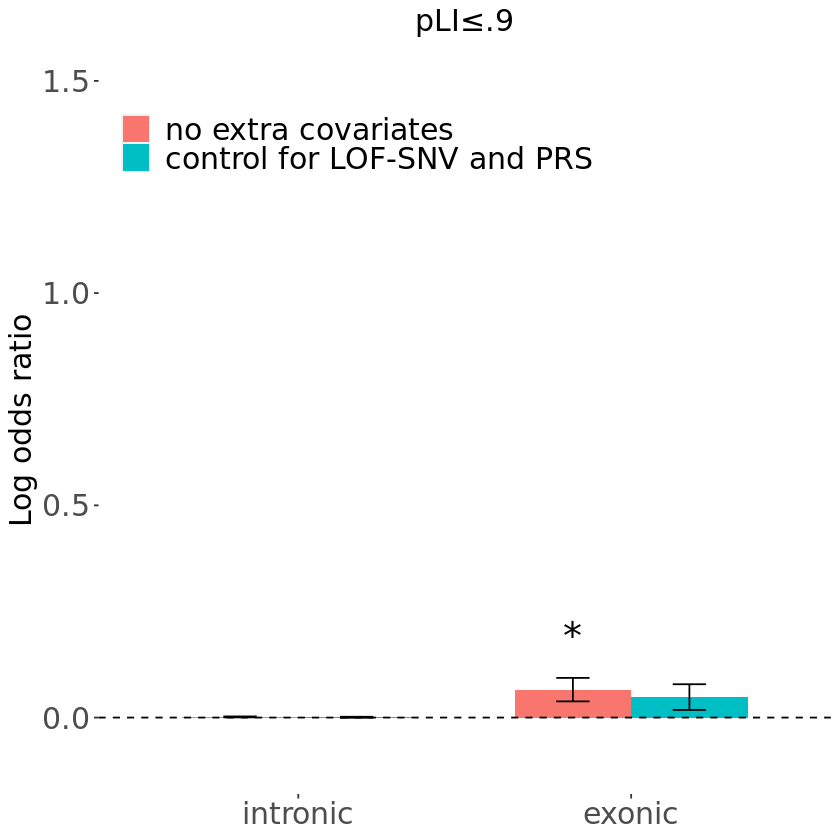

In [9]:
### Combined SVs & TRs
PRINT_INFO = TRUE
#PRINT_INFO = FALSE

flt = 'SQ70' # file_main is built with this SV filter. if you want to change the SV filter you should regenerate the file_main

null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + 
                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')

### no extra covariates...
print('no extra covariates.......................')
ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (ft in fts) {
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    svs_tmp = paste0('count_', ft_tmp) # add count_
    trs_tmp = paste0('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf) # add count_
    ft_tmp = c(svs_tmp, trs_tmp)
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    #new_df[c(ft_tmp, 'new_var')]

    #var = paste('count_', ft, sep="")
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
        
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + 
                                     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

### with LOF-SNV and PRS covariates...
print('with LOF-SNV and PRS covariates.......................')

null_formula = as.formula('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +
                          PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)')
# + PRS_EDU_Z + PRS_SCZ_Z  + PRS_ASD_Z
# + count_dnlof_inhlof

ORs_ncar = c()
ORs_plus_ncar = c()
ORs_minus_ncar = c()
log_ORs_ncar = c()
log_ORs_plus_ncar = c()
log_ORs_minus_ncar = c()
pvals_ncar = c()
ano_pvals_ncar = c()
sum_cases_ncar = c()
sum_controls_ncar = c()
for (ft in fts) {
    ft_tmp = unlist(strsplit(ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    svs_tmp = paste0('count_', ft_tmp) # add count_
    trs_tmp = paste0('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf) # add count_
    ft_tmp = c(svs_tmp, trs_tmp)
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    #new_df[c(ft_tmp, 'new_var')]

    #var = paste('count_', ft, sep="")
    var = 'new_var'
    ###print(var)
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases_ncar = c(sum_cases_ncar, sum_case)
    sum_controls_ncar = c(sum_controls_ncar, sum_control)
        
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +
                                     PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    #  + PRS_EDU_Z + PRS_SCZ_Z + PRS_ASD_Z
    # + count_dnlof_inhlof
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs_ncar = c(ORs_ncar, OR)
    ORs_plus_ncar = c(ORs_plus_ncar, OR_plus)
    ORs_minus_ncar = c(ORs_minus_ncar, OR_minus)
    log_ORs_ncar = c(log_ORs_ncar, log_OR)
    log_ORs_plus_ncar = c(log_ORs_plus_ncar, log_OR_plus)
    log_ORs_minus_ncar = c(log_ORs_minus_ncar, log_OR_minus)
    pvals_ncar = c(pvals_ncar, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals_ncar = c(ano_pvals_ncar, ano_pval)
}

sum_case_controls_ncar = paste(as.character(sum_cases_ncar), as.character(sum_controls_ncar), sep='/')

if (PRINT_INFO) {
    print('ORs_ncar:')
    print(ORs_ncar)
    print('ORs_plus_ncar:')
    print(ORs_plus_ncar)
    print('ORs_minus_ncar:')
    print(ORs_minus_ncar)
    print('log_ORs_ncar:')
    print(log_ORs_ncar)
    print('log_ORs_plus_ncar:')
    print(log_ORs_plus_ncar)
    print('log_ORs_minus_ncar:')
    print(log_ORs_minus_ncar)
    print('pvals_ncar:')
    print(pvals_ncar)
    print('ano_pvals_ncar:')
    print(ano_pvals_ncar)
    print('sum_cases_ncar:')
    print(sum_cases_ncar)
    print('sum_controls_ncar:')
    print(sum_controls_ncar)
    print('sum_case_controls_ncar:')
    print(sum_case_controls_ncar)
}

my_data = data.frame('fts' = fts, 'fts_labels' = fts_labels, 
                     'log_ORs_comb' = log_ORs, 'log_ORs_plus_comb' = log_ORs_plus, 'log_ORs_minus_comb' = log_ORs_minus, 
                     'ano_pval_comb' = ano_pvals, 
                     'sum_case_con_comb' = sum_case_controls, 
                     'log_ORs_ncar' = log_ORs_ncar, 'log_ORs_plus_ncar' = log_ORs_plus_ncar, 'log_ORs_minus_ncar' = log_ORs_minus_ncar, 
                     'ano_pval_ncar' = ano_pvals_ncar, 
                     'sum_case_con_ncar' = sum_case_controls_ncar)
#print(my_data)

this_cols = c('fts_labels', 
              'log_ORs_comb', 'log_ORs_plus_comb', 'log_ORs_minus_comb', 'ano_pval_comb', 
              'log_ORs_ncar', 'log_ORs_plus_ncar', 'log_ORs_minus_ncar', 'ano_pval_ncar')
# be carefull there are repeated names for the columns in the new column names. this may cause
# problems when accessing the columns
new_cols = c('Category', 
             'log OR, no extra cov.', 'upper 95% CI', 'lower 95% CI', 'ANOVA p-value', 
             'log OR, with LOF-SNV and PRS cov.', 'upper 95% CI', 'lower 95% CI', 'ANOVA p-value')
this_data_out = my_data[this_cols]
# formating the columns with number of digits
for (i_col in 2:length(this_cols)) {
    this_col = this_cols[i_col]
    this_data_out[this_col] = format(this_data_out[this_col], digits = 4, nsmall = 2)
}
colnames(this_data_out) <- new_cols
print(this_data_out)
file_out = paste0(dir_fig, 'burden_tests_table_svs_trs.tsv')
print(file_out)
write.table(this_data_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)


sub_fts_labels = c('intronic', 'exonic')
sub_fts_1 = c('PLIp9_DEV_BR_GENE_10_intron', 'PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr')
title_1 = 'fetal brain expressed genes with pLI≥.9'
fig_base_1 = 'devBrainPLI'
sub_fts_2 = c('DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr')
title_2 = 'fetal brain expressed genes'
fig_base_2 = 'devBrain'
sub_fts_3 = c('PLIp9_intron', 'PLIp9_cds + PLIp9_utr')
title_3 = 'pLI≥.9'
fig_base_3 = 'PLI'
sub_fts_4 = c('LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr')
title_4 = 'pLI≤.9'
fig_base_4 = 'LOWPLI'
#sub_fts_5 = c('FDR_ASD_intron', 'FDR_ASD_utr', 'FDR_ASD_cds', 'LOF_FDR_ASD_cds')
#title_5 = 'ASD genes'
#fig_base_5 = 'FDR_ASD'
#sub_fts = c('GNOCCHI_MAX_3_intron', 'GNOCCHI_MAX_3_utr', 'GNOCCHI_MAX_3_cds', 'GNOCCHI_MAX_3_?')

sub_flts_list = list(sub_fts_1, sub_fts_2, sub_fts_3, sub_fts_4)
title_list = list(title_1, title_2, title_3, title_4)
fig_base_list = list(fig_base_1, fig_base_2, fig_base_3, fig_base_4)

for (i_plot in 1:length(sub_flts_list)) {
#for (i_plot in 1:1) {
    sub_fts = sub_flts_list[[i_plot]]
    title = title_list[[i_plot]]
    fig_base = fig_base_list[[i_plot]]
    fig_name = paste0(dir_fig, 'combined_SVs_TRs_', fig_base, "_", flt, ".png")

    my_data_sub = my_data[my_data$fts %in% sub_fts,]
    my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)
    #print('subset df:')
    #print(my_data_sub)

    my_data_sub.melt = melt(my_data_sub, id.vars = c('fts', 'fts_labels', 
                                                     'log_ORs_plus_comb', 'log_ORs_minus_comb', 
                                                     'ano_pval_comb', 
                                                     'sum_case_con_comb', 
                                                     'log_ORs_plus_ncar', 'log_ORs_minus_ncar', 
                                                     'ano_pval_ncar', 
                                                     'sum_case_con_ncar'), 
                            variable.name = 'comb_ncar', value.name = 'log_ORs')

    my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_plus = ifelse(comb_ncar=='log_ORs_comb', log_ORs_plus_comb, log_ORs_plus_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_minus = ifelse(comb_ncar=='log_ORs_comb', log_ORs_minus_comb, log_ORs_minus_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, ano_pval = ifelse(comb_ncar=='log_ORs_comb', ano_pval_comb, ano_pval_ncar))
    my_data_sub.melt <- transform(my_data_sub.melt, sum_case_con = ifelse(comb_ncar=='log_ORs_comb', sum_case_con_comb, sum_case_con_ncar))

    sig <- sapply(my_data_sub.melt$ano_pval, get_pval_char)
    my_data_sub.melt$sig = sig

    #print('my_data_sub.melt:')
    #print(my_data_sub.melt)

    size_txt = 18
    size_sig = 8
    ylim_min = -0.1
    ylim_max = 1.5

    #geom_text(aes(label = tr_ntr), position=position_dodge(width=0.9), angle=90, hjust=0, vjust=0.5, size=2) +
    #plot.margin = margin(t = 1.5, l = 1.5, r = 1, b = 1, "cm"),

    base <- ggplot(my_data_sub.melt, aes(x = fts, y = log_ORs, fill = comb_ncar, ymin=log_ORs_minus , ymax=log_ORs_plus)) +
      geom_bar(position = position_dodge(width=0.7), stat = "identity", width = 0.7) +
      geom_errorbar(position = position_dodge(width=0.7), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = 0.2) +
      geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
      geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=0.7), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
      labs(y = "Log odds ratio", title = title) +
      theme(axis.text=element_text(size=size_txt),
            axis.text.x = element_text(angle = 0, vjust = 1, hjust=0.5, size=size_txt),
            axis.title.x = element_blank(),
            axis.title.y = element_text(size=size_txt),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5, size=size_txt), 
            legend.position = c(0.35, 0.9),
            legend.text = element_text(size=size_txt),
            legend.title = element_text(size=size_txt)
            ) +
      scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) +
      #scale_fill_discrete(name = 'Subjects', labels = c("combined", "SNV/indel non-carriers"), values = c("red", "green")) + 
      scale_fill_discrete(name = '', labels = c("no extra covariates", "control for LOF-SNV and PRS"))
      #scale_fill_manual(name = 'Subjects', labels = c("combined", "excluding case subjects with dnLOF, dnMIS and InhLOF SNVs/indels"), values=c("khaki", "indianred1")) +

    #if (i_plot != 5) { base <- base + ylim(c(ylim_min, ylim_max)) } else {base <- base + ylim(c(-3, 3))}
    base <- base + ylim(c(ylim_min, ylim_max))

    print(fig_name)
    print(base)
    ggsave(fig_name, width = 10, height = 6)
}